In [82]:
#Importing libraries
import pandas as pd
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
import numpy as np
import sdt.changepoint as c
import math

In [83]:
#import ARIMA libraries
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import numpy as np

In [84]:
# create a dataframe from the csv file
df_new_cases = pd.read_csv('../data/WHO-COVID-19-global-data.csv')
#df_vaccination = pd.read_csv('../data/owid-covid-data.csv')
df_vaccination = pd.read_csv('../data/country_vaccinations.csv')

In [85]:
# add moving average for new cases
#df_vaccination['moving_average_new_vaccinations'] = df_vaccination.groupby('iso_code')['new_vaccinations'].transform(lambda x: x.rolling(window=7).mean()) # OWID
df_vaccination['moving_average_new_vaccinations'] = df_vaccination.groupby('iso_code')['daily_vaccinations'].transform(lambda x: x.rolling(window=7).mean())

# rimuovi tutte le righe che non hanno un valore o hanno un valore a "0.0" per moving_average_new_cases
df_vaccination = df_vaccination.dropna(subset=['moving_average_new_vaccinations'])
df_vaccination = df_vaccination[df_vaccination['moving_average_new_vaccinations'] != 0.0]

In [86]:
# add moving average for new cases
df_new_cases['moving_average_new_cases'] = df_new_cases.groupby('Country_code')['New_cases'].transform(lambda x: x.rolling(window=7).mean())

# rimuovi tutte le righe che non hanno un valore o hanno un valore a "0.0" per moving_average_new_cases
df_new_cases = df_new_cases.dropna(subset=['moving_average_new_cases'])
df_new_cases = df_new_cases[df_new_cases['moving_average_new_cases'] != 0.0]

In [87]:
# firter data from 2021-07-16 to 2021-08-15
start_date = date(2021, 1, 1) 
og_start_date = date(2021, 7, 22)
og_end_date = date(2021, 8, 9)
end_date = date(2021, 8, 31)

difference = og_start_date - start_date
event_duration = og_end_date - og_start_date

# filter df_vaccination and df_new_cases from 2020-12-08 to 2021-08-31
start_vaccination = date(2020, 12, 8)
end_study = date(2021, 8, 31)
df_vaccination = df_vaccination[(df_vaccination['date'] >= str(start_vaccination)) & (df_vaccination['date'] <= str(end_study))]
df_vaccination = df_vaccination.reset_index(drop=True)
df_new_cases = df_new_cases[(df_new_cases['Date_reported'] >= str(start_vaccination)) & (df_new_cases['Date_reported'] <= str(end_study))]
df_new_cases = df_new_cases.reset_index(drop=True)

In [88]:
#filter by iso_cod that not contain "OWID" prefix
df_vaccination = df_vaccination[~df_vaccination['iso_code'].str.contains("OWID")]

# aggragate by iso_code and date and sum total_cases, total_deaths, population, total_vaccinations, new_cases, mind positive_rate, max positive_rate,KEEP LOCATION 
#df_vaccination = df_vaccination.groupby(['iso_code', 'date']).agg({'people_vaccinated':'sum', 'new_vaccinations': 'sum', 'location': 'max', 'moving_average_new_vaccinations': 'sum'})
df_vaccination = df_vaccination.groupby(['iso_code', 'date']).agg({'total_vaccinations':'sum', 'daily_vaccinations': 'sum', 'country': 'max', 'moving_average_new_vaccinations': 'sum'})

In [89]:
#aggiungi alla riga attuale nella colonna iso_code il valore iso
convert_ISO_3166_2_to_1 = {
    'AF':'AFG',
    'AX':'ALA',
    'AL':'ALB',
    'DZ':'DZA',
    'AS':'ASM',
    'AD':'AND',
    'AO':'AGO',
    'AI':'AIA',
    'AQ':'ATA',
    'AG':'ATG',
    'AR':'ARG',
    'AM':'ARM',
    'AW':'ABW',
    'AU':'AUS',
    'AT':'AUT',
    'AZ':'AZE',
    'BS':'BHS',
    'BH':'BHR',
    'BD':'BGD',
    'BB':'BRB',
    'BY':'BLR',
    'BE':'BEL',
    'BZ':'BLZ',
    'BJ':'BEN',
    'BM':'BMU',
    'BT':'BTN',
    'BO':'BOL',
    'BA':'BIH',
    'BW':'BWA',
    'BV':'BVT',
    'BR':'BRA',
    'IO':'IOT',
    'BN':'BRN',
    'BG':'BGR',
    'BF':'BFA',
    'BI':'BDI',
    'KH':'KHM',
    'CM':'CMR',
    'CA':'CAN',
    'CV':'CPV',
    'KY':'CYM',
    'CF':'CAF',
    'TD':'TCD',
    'CL':'CHL',
    'CN':'CHN',
    'CX':'CXR',
    'CC':'CCK',
    'CO':'COL',
    'KM':'COM',
    'CG':'COG',
    'CD':'COD',
    'CK':'COK',
    'CR':'CRI',
    'CI':'CIV',
    'HR':'HRV',
    'CU':'CUB',
    'CY':'CYP',
    'CZ':'CZE',
    'DK':'DNK',
    'DJ':'DJI',
    'DM':'DMA',
    'DO':'DOM',
    'EC':'ECU',
    'EG':'EGY',
    'SV':'SLV',
    'GQ':'GNQ',
    'ER':'ERI',
    'EE':'EST',
    'ET':'ETH',
    'FK':'FLK',
    'FO':'FRO',
    'FJ':'FJI',
    'FI':'FIN',
    'FR':'FRA',
    'GF':'GUF',
    'PF':'PYF',
    'TF':'ATF',
    'GA':'GAB',
    'GM':'GMB',
    'GE':'GEO',
    'DE':'DEU',
    'GH':'GHA',
    'GI':'GIB',
    'GR':'GRC',
    'GL':'GRL',
    'GD':'GRD',
    'GP':'GLP',
    'GU':'GUM',
    'GT':'GTM',
    'GG':'GGY',
    'GN':'GIN',
    'GW':'GNB',
    'GY':'GUY',
    'HT':'HTI',
    'HM':'HMD',
    'VA':'VAT',
    'HN':'HND',
    'HK':'HKG',
    'HU':'HUN',
    'IS':'ISL',
    'IN':'IND',
    'ID':'IDN',
    'IR':'IRN',
    'IQ':'IRQ',
    'IE':'IRL',
    'IM':'IMN',
    'IL':'ISR',
    'IT':'ITA',
    'JM':'JAM',
    'JP':'JPN',
    'JE':'JEY',
    'JO':'JOR',
    'KZ':'KAZ',
    'KE':'KEN',
    'KI':'KIR',
    'KP':'PRK',
    'KR':'KOR',
    'KW':'KWT',
    'KG':'KGZ',
    'LA':'LAO',
    'LV':'LVA',
    'LB':'LBN',
    'LS':'LSO',
    'LR':'LBR',
    'LY':'LBY',
    'LI':'LIE',
    'LT':'LTU',
    'LU':'LUX',
    'MO':'MAC',
    'MK':'MKD',
    'MG':'MDG',
    'MW':'MWI',
    'MY':'MYS',
    'MV':'MDV',
    'ML':'MLI',
    'MT':'MLT',
    'MH':'MHL',
    'MQ':'MTQ',
    'MR':'MRT',
    'MU':'MUS',
    'YT':'MYT',
    'MX':'MEX',
    'FM':'FSM',
    'MD':'MDA',
    'MC':'MCO',
    'MN':'MNG',
    'ME':'MNE',
    'MS':'MSR',
    'MA':'MAR',
    'MZ':'MOZ',
    'MM':'MMR',
    'NA':'NAM',
    'NR':'NRU',
    'NP':'NPL',
    'NL':'NLD',
    'AN':'ANT',
    'NC':'NCL',
    'NZ':'NZL',
    'NI':'NIC',
    'NE':'NER',
    'NG':'NGA',
    'NU':'NIU',
    'NF':'NFK',
    'MP':'MNP',
    'NO':'NOR',
    'OM':'OMN',
    'PK':'PAK',
    'PW':'PLW',
    'PS':'PSE',
    'PA':'PAN',
    'PG':'PNG',
    'PY':'PRY',
    'PE':'PER',
    'PH':'PHL',
    'PN':'PCN',
    'PL':'POL',
    'PT':'PRT',
    'PR':'PRI',
    'QA':'QAT',
    'RE':'REU',
    'RO':'ROU',
    'RU':'RUS',
    'RW':'RWA',
    'BL':'BLM',
    'SH':'SHN',
    'KN':'KNA',
    'LC':'LCA',
    'MF':'MAF',
    'PM':'SPM',
    'VC':'VCT',
    'WS':'WSM',
    'SM':'SMR',
    'ST':'STP',
    'SA':'SAU',
    'SN':'SEN',
    'RS':'SRB',
    'SC':'SYC',
    'SL':'SLE',
    'SG':'SGP',
    'SK':'SVK',
    'SI':'SVN',
    'SB':'SLB',
    'SO':'SOM',
    'ZA':'ZAF',
    'GS':'SGS',
    'ES':'ESP',
    'LK':'LKA',
    'SD':'SDN',
    'SR':'SUR',
    'SJ':'SJM',
    'SZ':'SWZ',
    'SE':'SWE',
    'CH':'CHE',
    'SY':'SYR',
    'TW':'TWN',
    'TJ':'TJK',
    'TZ':'TZA',
    'TH':'THA',
    'TL':'TLS',
    'TG':'TGO',
    'TK':'TKL',
    'TO':'TON',
    'TT':'TTO',
    'TN':'TUN',
    'TR':'TUR',
    'TM':'TKM',
    'TC':'TCA',
    'TV':'TUV',
    'UG':'UGA',
    'UA':'UKR',
    'AE':'ARE',
    'GB':'GBR',
    'US':'USA',
    'UM':'UMI',
    'UY':'URY',
    'UZ':'UZB',
    'VU':'VUT',
    'VE':'VEN',
    'VN':'VNM',
    'VG':'VGB',
    'VI':'VIR',
    'WF':'WLF',
    'EH':'ESH',
    'YE':'YEM',
    'ZM':'ZMB',
    'ZW':'ZWE'
}

In [90]:
# set country_code like index
df_new_cases = df_new_cases.set_index('Country_code')
country_list = df_new_cases.index.get_level_values('Country_code').unique()

for code in country_list:
    if code not in convert_ISO_3166_2_to_1:
        #print(code , "NOT FOUND")
        continue
    iso = convert_ISO_3166_2_to_1[code]
    df_new_cases.loc[(df_new_cases.index.get_level_values('Country_code') == code), 'iso_code'] = iso

In [91]:
# rename columns of date_reported
df_new_cases.rename(columns={'Date_reported':'date'}, inplace=True) 

In [92]:
# aggragate by iso_code and date and sum total_cases, total_deaths, population, total_vaccinations, new_cases, mind positive_rate, max positive_rate,KEEP LOCATION 
df_new_cases = df_new_cases.groupby(['iso_code', 'date']).agg({'Country': 'sum', 'New_cases': 'sum', 'moving_average_new_cases': 'sum'})

In [93]:
# save dataframe in csv file
df_new_cases.to_csv('./out/ARIMA/ARIMA_dataframe.csv')
df_vaccination.to_csv('./out/ARIMA/ARIMA_vaccinations.csv')

In [94]:
'''for iso_code in df_vaccination.index.get_level_values('iso_code').unique():
    plt.plot(df_vaccination.loc[iso_code]['moving_average_new_vaccinations'], label='vaccinations')
    plt.title(df_vaccination.loc[iso_code]['country'].unique()[0])
    plt.ylabel("new vaccinations")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    plt.show()'''

'for iso_code in df_vaccination.index.get_level_values(\'iso_code\').unique():\n    plt.plot(df_vaccination.loc[iso_code][\'moving_average_new_vaccinations\'], label=\'vaccinations\')\n    plt.title(df_vaccination.loc[iso_code][\'country\'].unique()[0])\n    plt.ylabel("new vaccinations")\n    plt.xlabel("Date")\n    plt.xticks(rotation=90)\n    plt.show()'

In [95]:

# crea una lista di tutti gli iso_code presenti in df_new_cases
iso_code_list = df_new_cases.index.get_level_values('iso_code').unique().tolist()

In [96]:
def train_model(df_train, df_test):
    min_rmse = 10000000
    best_model = None
    best_d = 0
    best_pred = None
    for diff in range(0, 3):
        model = pm.auto_arima(df_train["moving_average_new_cases"], X=df_train[["moving_average_new_vaccinations"]], start_p=0, start_q=0,
                              # usiamo il test adf per la stazionarietà.
                              test='adf',
                              max_p=5, max_q=5,
                              d=diff,  # ordine della prima differenziazione
                              error_action='ignore', trace=True,
                              suppress_warnings=True,
                              random_state=42,
                              stagionality=True,
                              maxiter=500, m=4, stationary=False)

        pred, ci = model.predict(n_periods=len(
            df_test["moving_average_new_cases"]), X=df_test[["moving_average_new_vaccinations"]], alpha=0.05, return_conf_int=True)

        rmse = math.sqrt(mean_squared_error(
            df_test["moving_average_new_cases"], pred))
        # print('Test RMSE: %.3f' % rmse)
        if rmse < min_rmse:
            min_rmse = rmse
            best_model = model
            best_pred = pred
            best_d = diff
    return best_model, best_pred, best_d, min_rmse

Text(0, 0.5, 'Current MA - Previous MA')

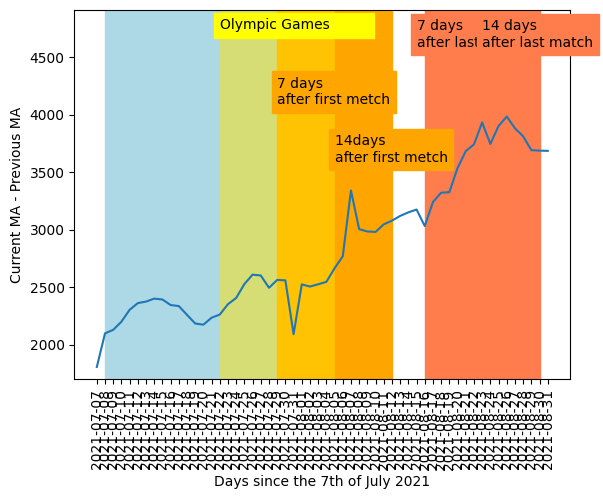

In [97]:

df_tmp = df_new_cases.loc[iso_code_list[80]]
df_tmp = df_tmp.reset_index(drop=False)
df_tmp = df_tmp[df_tmp['date'] >= '2021-07-07']
df_tmp = df_tmp.reset_index(drop=True)
df_tmp = df_tmp.set_index('date')
plt.plot(df_tmp['moving_average_new_cases'], label='new cases')

ymax = plt.ylim()[1]
plt.ylim(ymax=ymax*1.20)

plt.text('2021-07-22', ymax+650, "Olympic Games         ", rotation=0, color="black", backgroundcolor="yellow")
plt.text("2021-07-29", ymax, "7 days \nafter first metch", rotation=0, backgroundcolor="orange")
plt.text("2021-08-05", ymax-500, "14days \nafter first metch", rotation=0, backgroundcolor="orange")
plt.text('2021-08-15', ymax+500, "7 days \nafter last match", rotation=0, backgroundcolor="#FF7D4D")
plt.text('2021-08-23', ymax+500, "14 days \nafter last match", rotation=0, backgroundcolor="#FF7D4D")

plt.axvspan('2021-07-08', '2021-07-29', color = 'lightblue', label = '14 days before first game of olympic games')
plt.axvspan('2021-07-29', '2021-08-05', color = 'orange', label = '7 days after first game of olympic games')
plt.axvspan('2021-07-22', '2021-08-09', facecolor='#ffe206', alpha=0.5)
plt.axvspan('2021-08-05', '2021-08-12', color = 'orange', label = '14 days after first game of olympic games')
plt.axvspan('2021-08-16', '2021-08-23', color = '#FF7D4D', label = '14 days after last game of olympic games')
plt.axvspan('2021-08-23', '2021-08-30', color = '#FF7D4D', label = '14 days after last game of olympic games')

plt.xlabel("Days since the 7th of July 2021")
plt.xticks(rotation=90)
plt.ylabel("Current MA - Previous MA")

2021-04-05
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=630.451, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=791.656, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=584.246, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=667.000, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=791.798, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=582.450, Time=0.05 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=584.342, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=580.733, Time=0.34 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=573.006, Time=0.35 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=571.232, Time=0.34 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=630.328, Time=0.31 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=564.684, Time=0.85 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(2,0,0)(2,0,1)[4] intercept   : AIC=566.510, Time=0.56 sec
 ARIMA(2,0,0)(1,0,1)[4] inter

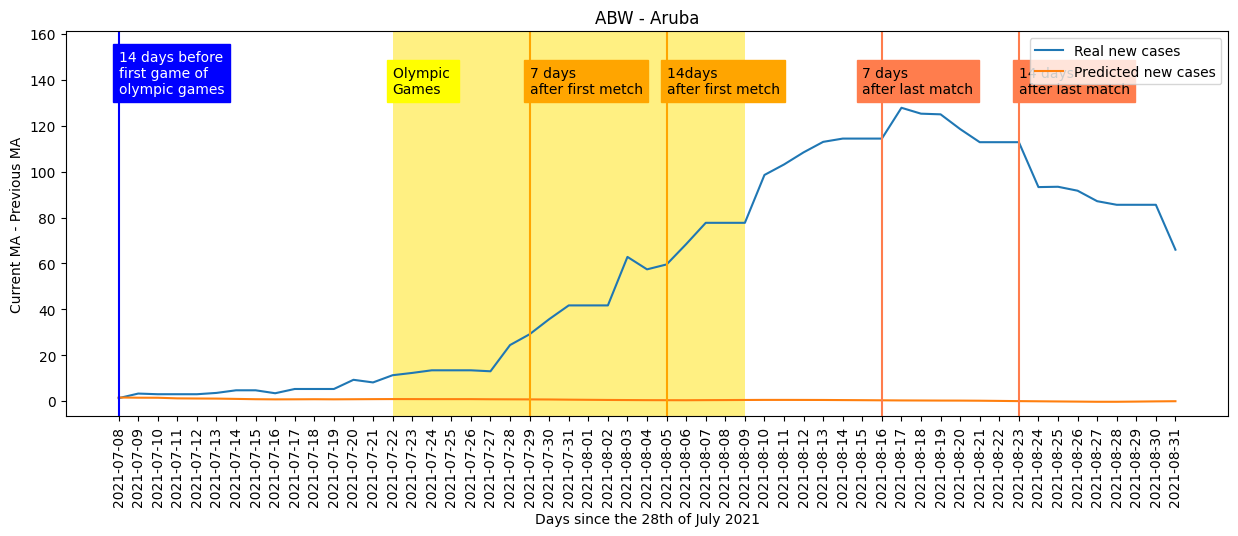

2021-03-01
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=1617.287, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2026.971, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=2026.435, Time=0.05 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(0,0,0)(1,0,2)[4] intercept   : AIC=1617.412, Time=0.60 sec
 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=1608.679, Time=0.42 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=1402.523, Time=0.55 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=1404.199, Time=0.69 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=1406.344, Time=0.33 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC

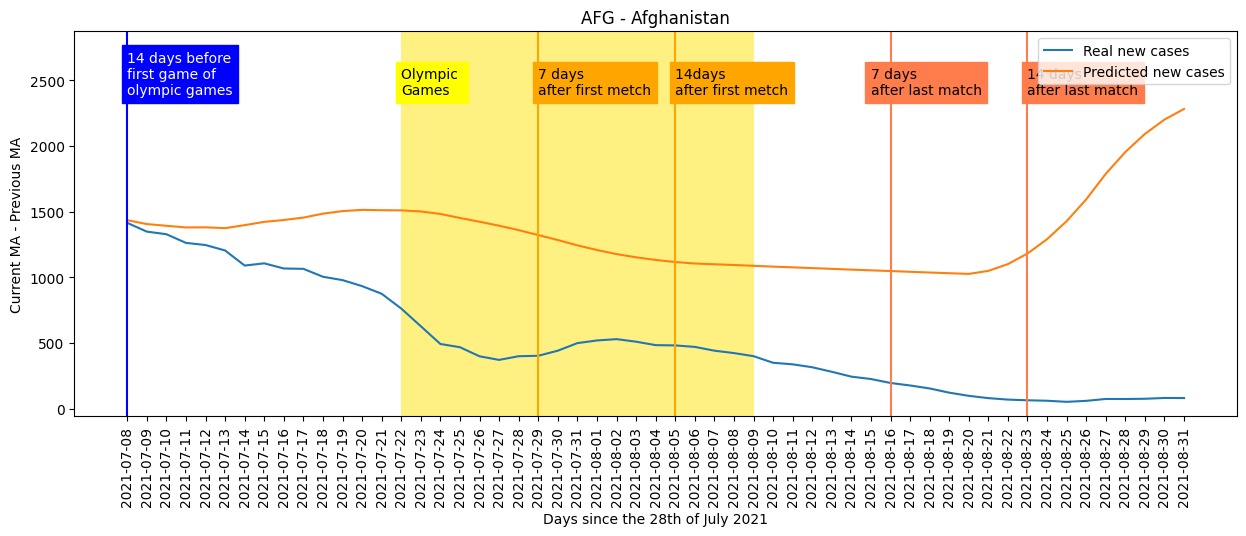

2021-03-08
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=1117.696, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=1414.884, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=883.271, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1893.231, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=882.837, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=883.769, Time=0.19 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=877.964, Time=0.37 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=873.812, Time=0.36 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=875.154, Time=0.41 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=873.945, Time=0.74 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=872.472, Time=0.43 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=876.657, Time=0.17 sec
 ARIMA(0,0,0)(1,0,2)[4] intercept   : AIC=1103.198, Time=0.40 sec
 ARIMA(2,0,0)(1,0,2)[4] i

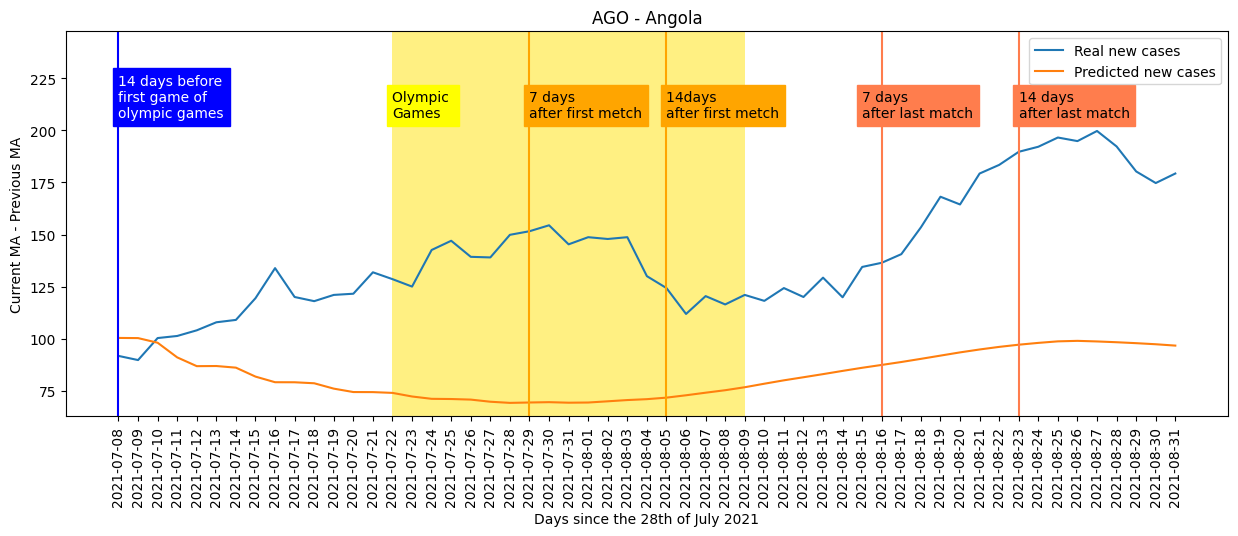

2021-02-11
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=271.251, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=292.841, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=174.364, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=225.700, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=290.884, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=172.699, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=174.268, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=175.761, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=173.183, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=173.931, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=240.485, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=175.763, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=170.968, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[4]             : AIC=172.615, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[4]  

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=172.963, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=170.041, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=172.660, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=172.975, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=168.044, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=171.505, Time=0.06 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=171.366, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=171.293, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=171.619, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=169.747, Time=0.12 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 0.737 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[4]             : AIC=206.572, Time=0.13 sec


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,2,0)(0,0,0)[4]             : AIC=205.518, Time=0.06 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=159.084, Time=0.12 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=173.553, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=168.691, Time=0.05 sec
 ARIMA(1,2,0)(2,0,0)[4]             : AIC=159.572, Time=0.14 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=160.047, Time=0.14 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=158.629, Time=0.09 sec
 ARIMA(1,2,0)(0,0,2)[4]             : AIC=159.879, Time=0.20 sec
 ARIMA(1,2,0)(1,0,2)[4]             : AIC=161.879, Time=0.40 sec
 ARIMA(0,2,0)(0,0,1)[4]             : AIC=206.784, Time=0.05 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=159.801, Time=0.12 sec
 ARIMA(1,2,1)(0,0,1)[4]             : AIC=159.765, Time=0.13 sec
 ARIMA(2,2,1)(0,0,1)[4]             : AIC=161.759, Time=0.23 sec
 ARIMA(1,2,0)(0,0,1)[4] intercept   : AIC=160.622, Time=0.16 sec

Best model:  ARIMA(1,2,0)(0,0,1)[4]          
Total fit time: 2.112 seconds
Performing st

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=271.251, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=292.841, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=174.364, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=225.700, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=290.884, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=172.699, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=174.268, Time=0.14 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=175.761, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=173.183, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=173.931, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=240.485, Time=0.11 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=175.763, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=170.968, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[4]             : AIC=172.615, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[4]             : AIC=172.519, Time=0.11 sec
 ARIMA(1,0,0)(1,0,1)[4]  

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


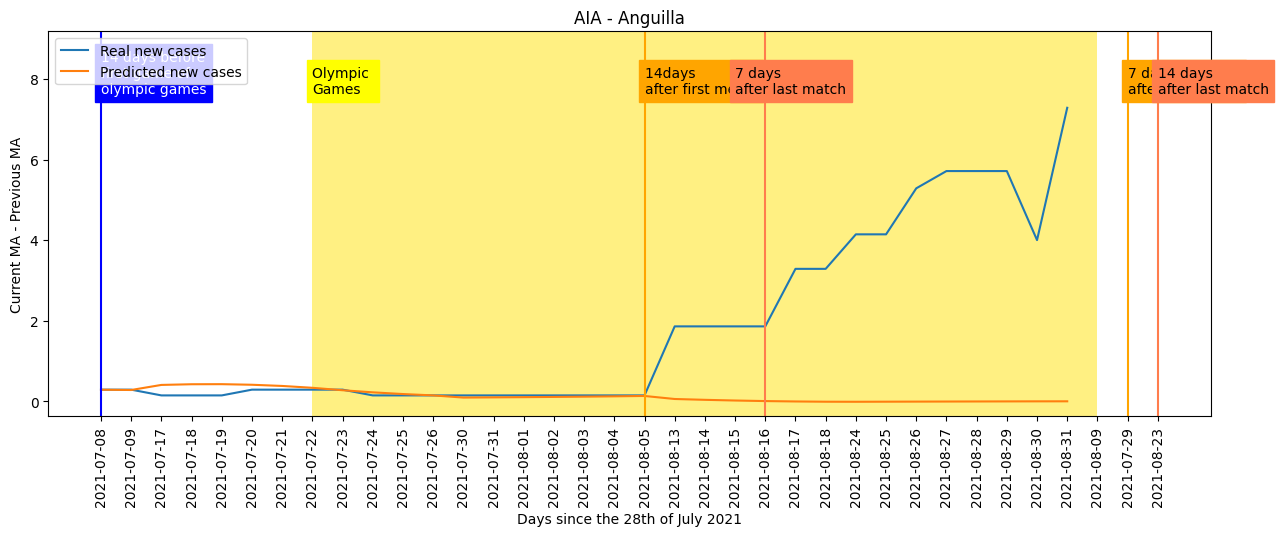

2021-01-17
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2542.584, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=2657.778, Time=0.07 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=1396.219, Time=0.12 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=1377.965, Time=0.25 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=1355.697, Time=0.64 sec
 ARIMA(1,0,1)(2,0,1)[4] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=1364.473, Time=0.36 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=inf, Time

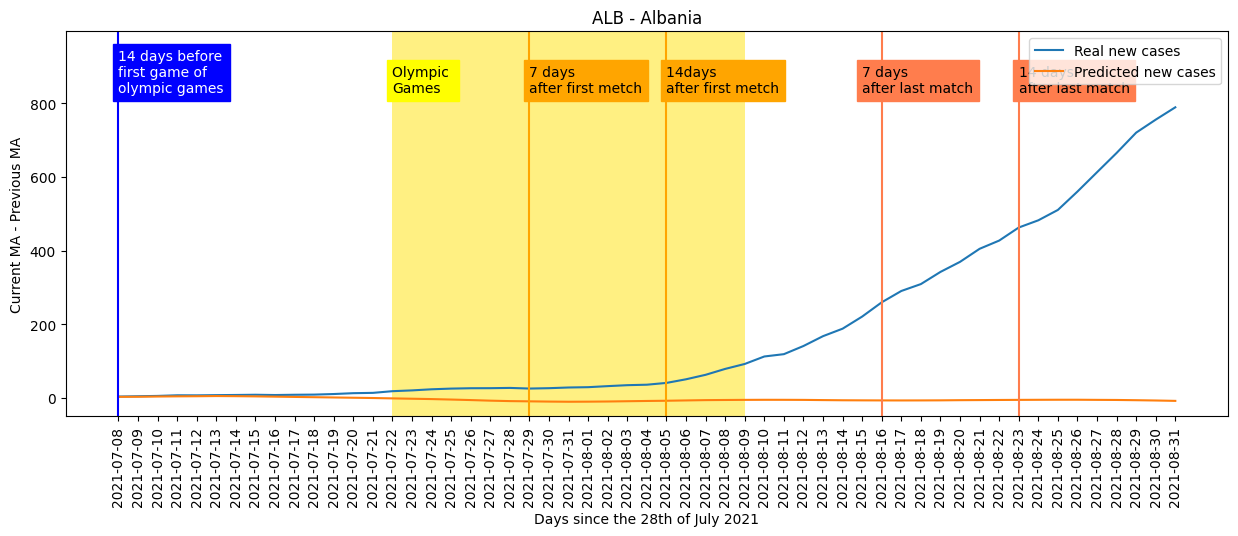

2021-02-01
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=909.049, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=1272.837, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=744.496, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=973.590, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1487.099, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=746.331, Time=0.11 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=746.251, Time=0.44 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=742.364, Time=0.26 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=744.597, Time=0.17 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=744.329, Time=0.40 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=744.295, Time=0.50 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=746.579, Time=0.38 sec
 ARIMA(1,0,0)(2,0,2)[4] intercept   : AIC=745.634, Time=0.57 sec
 ARIMA(2,0,0)(1,0,1)[4] intercept   : AIC=740.351, Time=0.47 sec
 ARIMA(2,0,0)(0,0,1)[4]

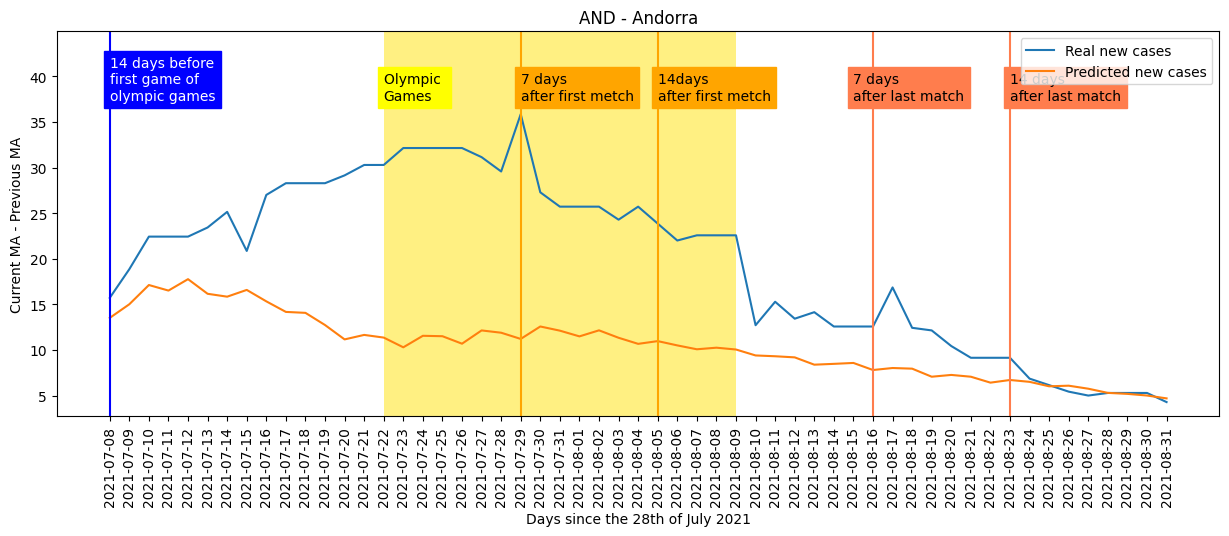

2021-01-12
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2827.744, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=3574.090, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=2313.194, Time=0.28 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=2268.989, Time=0.58 sec
 ARIMA(0,0,0)(2,0,1)[4] intercept   : AIC=2675.945, Time=0.27 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=1832.243, Time=0.53 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=1837.043, Time=0.39 sec
 ARIMA(1,0,1)(2,0,1)[4] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(2,0,1)(2,0,0)[4] intercept   : AIC=1818.

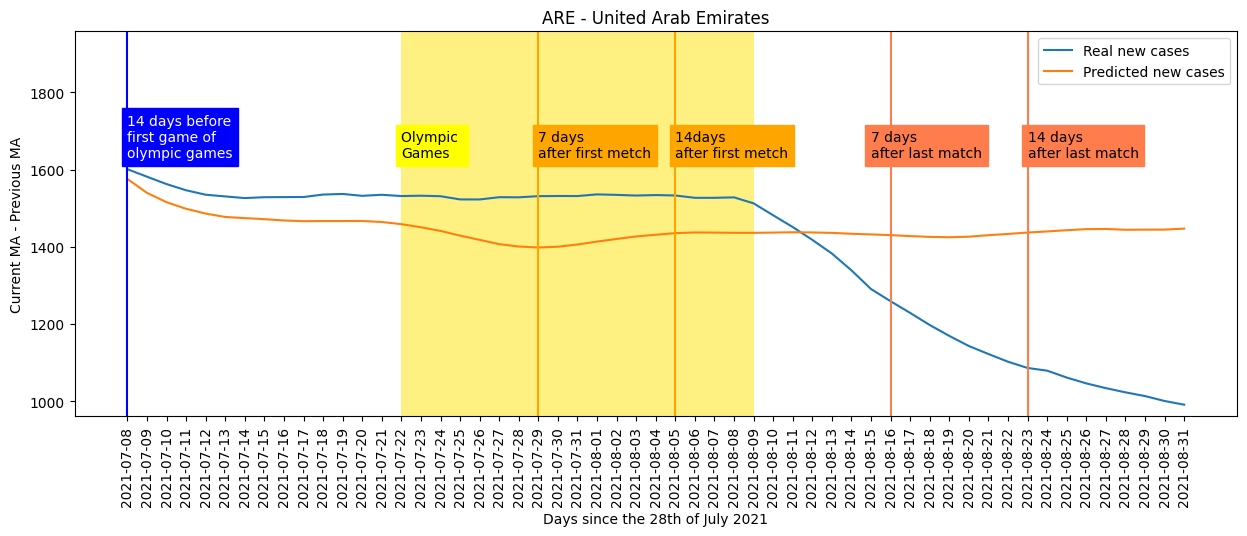

2021-01-05
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=3802.853, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=2915.715, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=3668.412, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=4640.736, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=2916.299, Time=0.82 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=2912.327, Time=0.49 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=2910.134, Time=0.33 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=2912.979, Time=0.48 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=inf, Time=1.03 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=2832.541, Time=0.46 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=2832.177, Time=0.34 sec
 ARIMA(2,0,0)(1,0,0)[4] interce

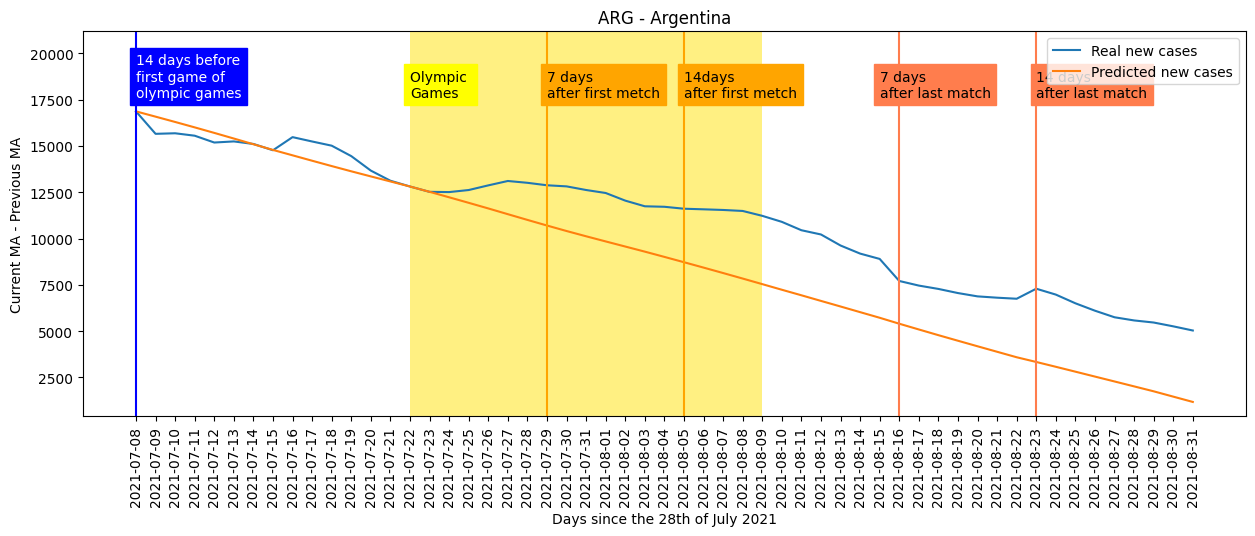

2021-04-07
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=1208.251, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1375.523, Time=0.03 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=733.617, Time=0.13 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=707.415, Time=0.18 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=699.172, Time=0.24 sec
 ARIMA(1,0,1)(2,0,1)[4] intercept   : AIC=700.147, Time=0.39 sec
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=699.859, Time=0.28 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=inf, Time

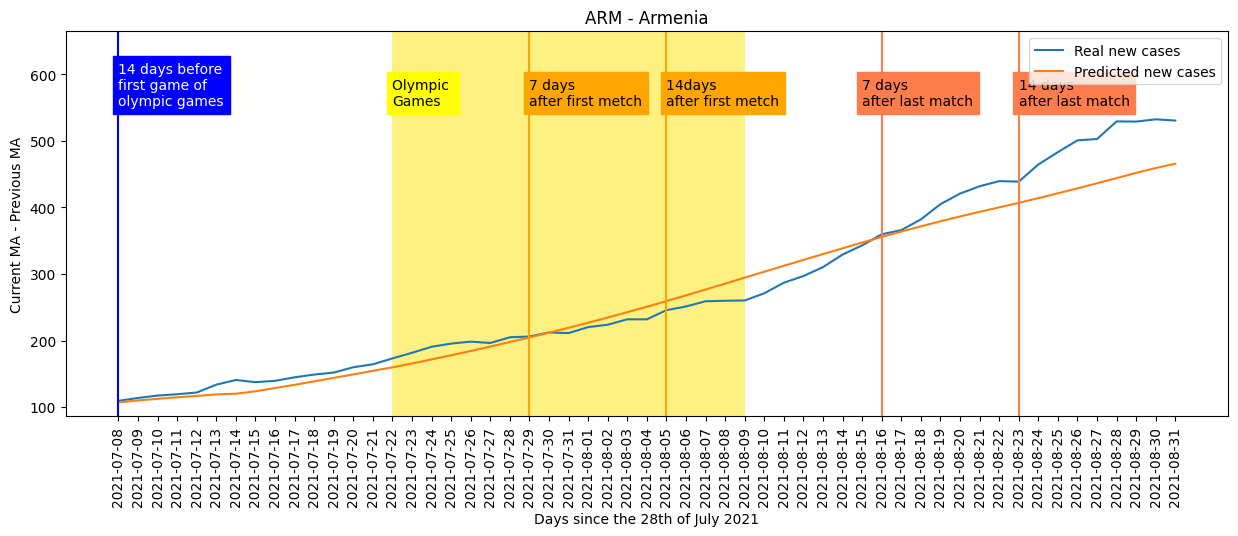

2021-02-23
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=592.274, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=779.719, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=458.700, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=787.681, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=456.719, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=460.433, Time=0.26 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=458.325, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=458.310, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=658.311, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 2.169 seconds
Performing stepwise search to

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=449.275, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=445.294, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=448.276, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=448.070, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=445.533, Time=0.03 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=447.143, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=447.069, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=446.475, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=446.400, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=445.175, Time=0.12 sec
 ARIMA(1,1,1)(1,0,0)[4] intercept   : AIC=447.173, Time=0.25 sec
 ARIMA(1,1,1)(0,0,1)[4] intercept   : AIC=447.172, Time=0.31 sec
 ARIMA(1,1,1)(1,0,1)[4] intercept   : AIC=449.036, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[4] intercept   : AIC=447.081, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[4] intercept   : AIC=447.096, Time=0.23 sec
 ARIMA(0,1,2)(0,0,0)[4] i

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,2,0)(0,0,0)[4]             : AIC=527.935, Time=0.06 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=494.705, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=449.026, Time=0.16 sec
 ARIMA(0,2,1)(0,0,0)[4]             : AIC=447.178, Time=0.08 sec
 ARIMA(0,2,1)(1,0,0)[4]             : AIC=449.076, Time=0.08 sec
 ARIMA(0,2,1)(1,0,1)[4]             : AIC=451.177, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[4]             : AIC=448.450, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[4]             : AIC=448.389, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=492.728, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[4]             : AIC=450.881, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,2,1)(0,0,0)[4]          
Total fit time: 1.209 seconds
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=592.274, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=779.719, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=458.700, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=787.681, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=456.719, Time=0.07 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=460.433, Time=0.25 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=458.325, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=458.310, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=658.311, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=inf, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 2.182 seconds


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


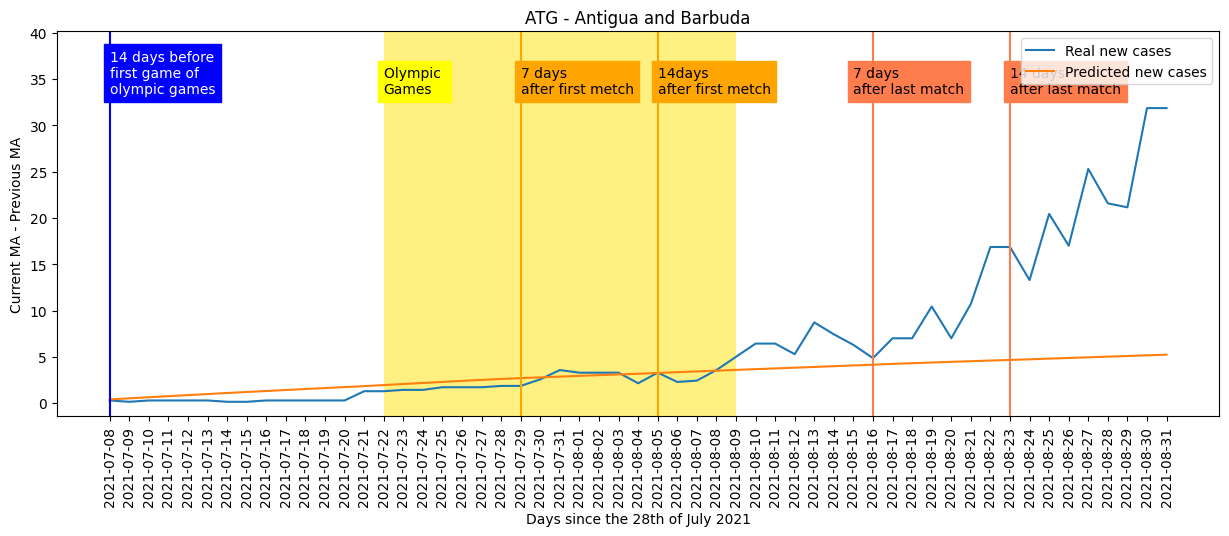

2021-02-28
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=941.021, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=959.404, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=819.568, Time=0.08 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=903.357, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1467.590, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=790.419, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=926.419, Time=0.06 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=872.517, Time=0.08 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=791.944, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=792.080, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=926.488, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=1165.302, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=788.706, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[4]             : AIC=790.711, Time=0.17 sec
 ARIMA(1,0,0)(0,0,1)[4]

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,0,1)(0,0,0)[4]             : AIC=1166.987, Time=0.06 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4]          
Total fit time: 1.877 seconds
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=792.003, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=788.117, Time=0.07 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=791.880, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=791.916, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=786.655, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=790.007, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=790.010, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=790.000, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=789.966, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=788.394, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 1.093 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,0)(1,0,1)[4]             : AIC=87

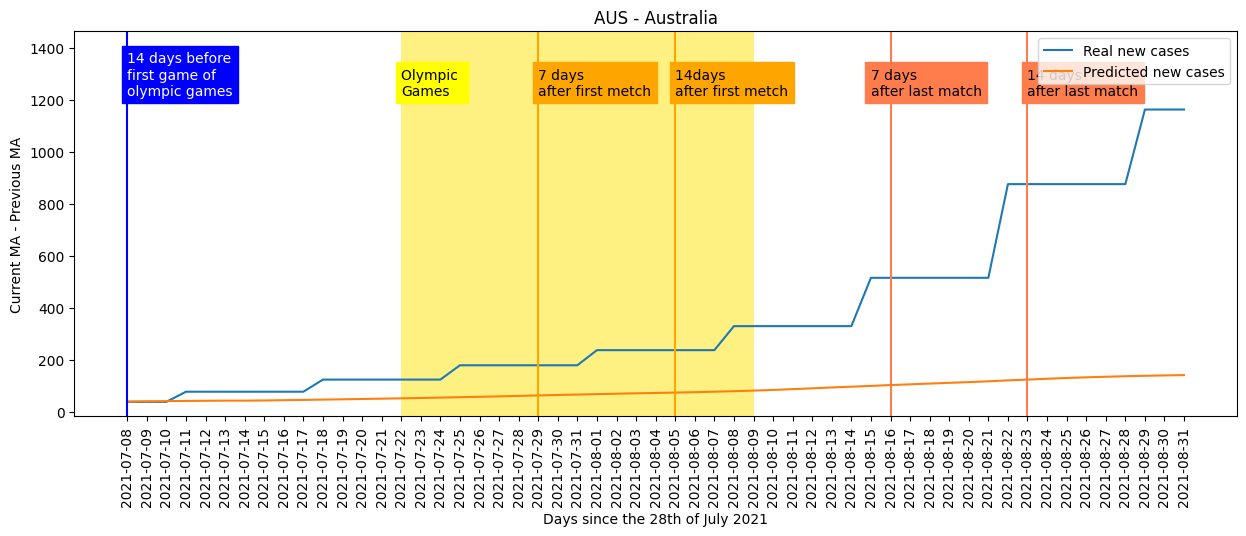

2021-01-15
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=2151.855, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2973.565, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=3762.155, Time=0.01 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=2389.431, Time=0.25 sec
 ARIMA(0,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(0,0,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=2842.083, Time=0.26 sec
 ARIMA(0,0,0)(2,0,2)[4] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=1782.538, Time=0.74 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=1809.886, Time=0.43 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf,

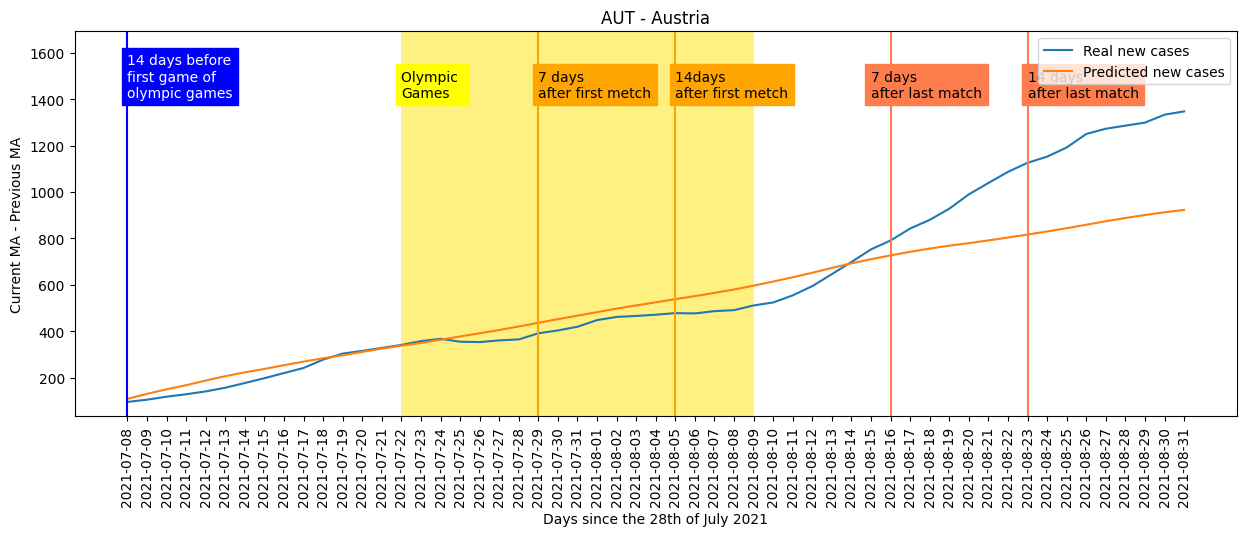

2021-01-24
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=2018.423, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2657.624, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=3351.215, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(2,0,1)[4] intercept   : AIC=1901.415, Time=1.02 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=1909.089, Time=0.81 sec
 ARIMA(0,0,0)(2,0,2)[4] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(0,0,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,0,1)(2,0,1)[4] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(1,0,1)(2,0,1)[4] intercept   : AIC=1604.119, Time=1.58 sec
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=1610.928,

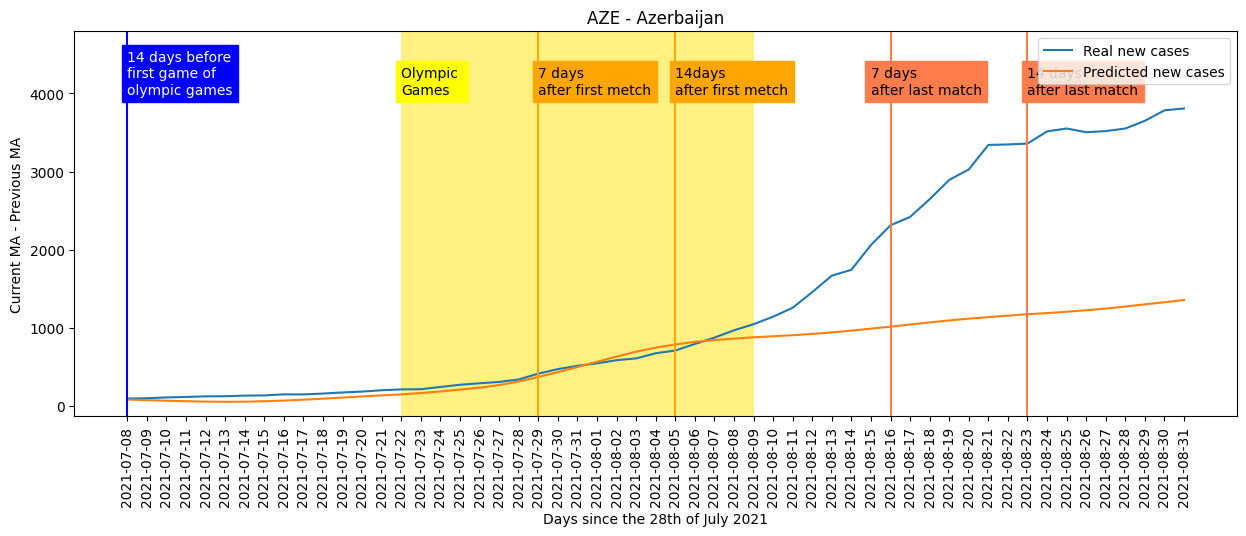

Error in BDI: 'BDI'
2021-01-04
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=2694.573, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=3252.927, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=4136.003, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=3162.263, Time=0.07 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=3128.791, Time=0.13 sec
 ARIMA(0,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,0,0)(1,0,2)[4] intercept   : AIC=3130.468, Time=0.33 sec
 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=2596.460, Time=0.76 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=2224.521, Time=0.96 sec
 ARIMA(1,0,1)(1,0,0)[

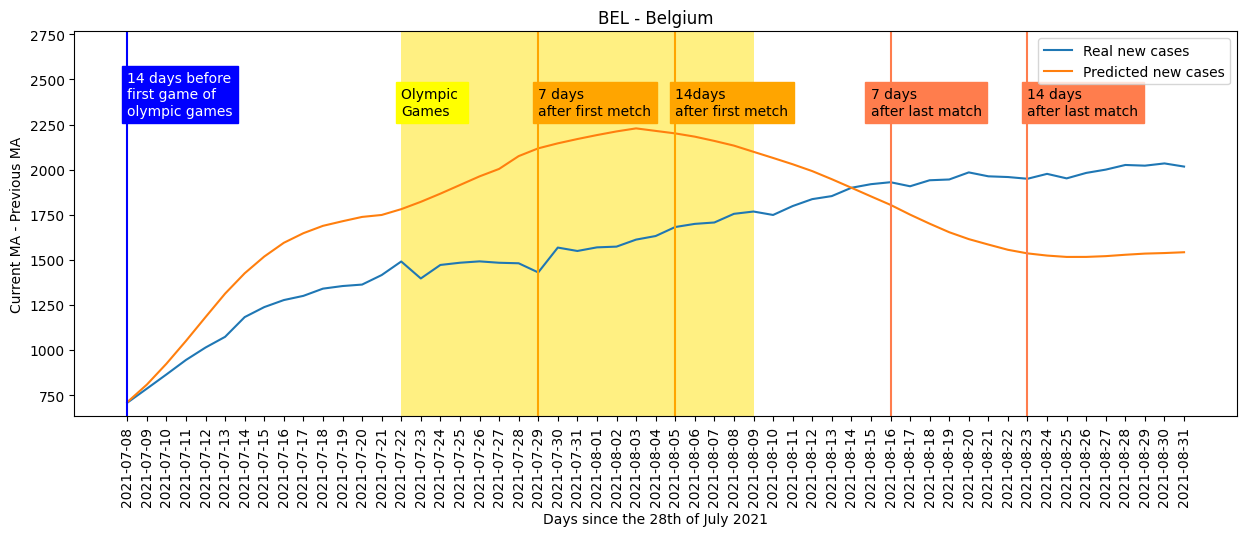

2021-05-19
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=79.047, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=102.038, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=18.000, Time=0.24 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=204.447, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=16.750, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=18.528, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=20.001, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=17.854, Time=0.18 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=18.221, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=22.099, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=inf, Time=0.07 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 1.918 seconds
Performing stepwise search to min

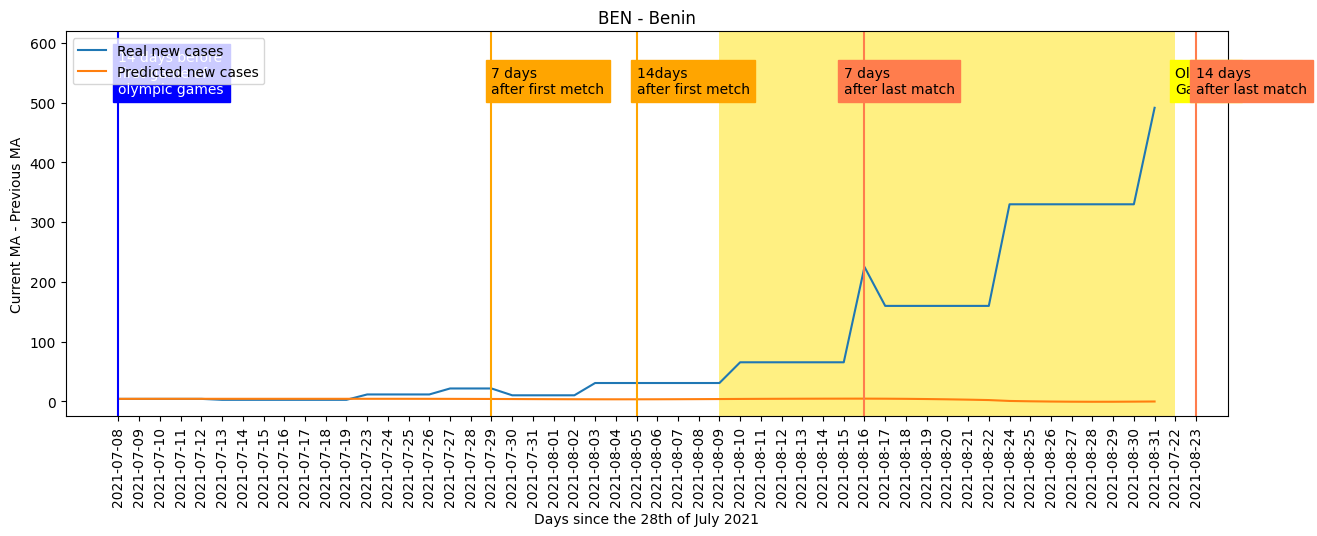

2021-06-09
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=53.722, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=34.904, Time=0.17 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=53.270, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=36.399, Time=0.09 sec
 ARIMA(1,0,0)(2,1,0)[4] intercept   : AIC=36.466, Time=0.25 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=33.481, Time=0.29 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(1,0,0)(2,1,1)[4] intercept   : AIC=35.373, Time=0.43 sec
 ARIMA(1,0,0)(1,1,2)[4] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(1,0,0)(0,1,2)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,0,0)(2,1,2)[4] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(2,0,0)(1,1,1)[4] intercept   : AIC=35.199, Time=0.44 sec
 ARIMA(1,0,1)(1,1,1)[4] intercept   : AIC=inf, Time=0.41 

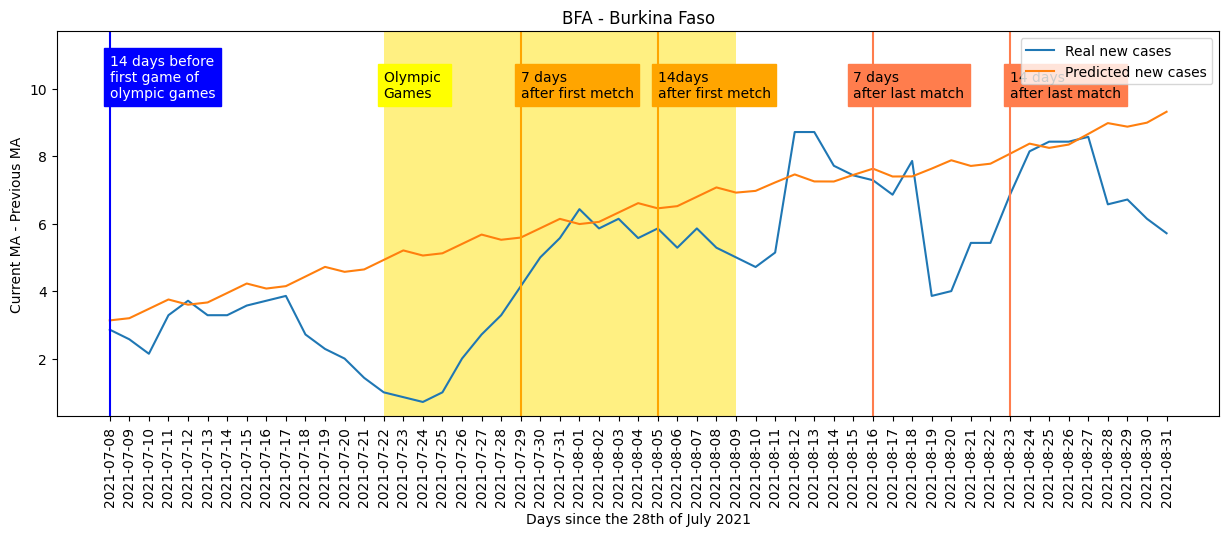

2021-02-02
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2892.789, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=3583.993, Time=0.02 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=2787.825, Time=0.05 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=2783.443, Time=0.16 sec
 ARIMA(0,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=1887.415, Time=1.04 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=1890.985, Time=0.75 sec
 ARIMA(1,0,1)(2,0,1)[4] intercept   : AIC=1887.160, Time=1.17 sec
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=1889.199, Time=0.73 sec
 ARIMA(1,0,1)(2,0,2)[4] intercept   : AIC

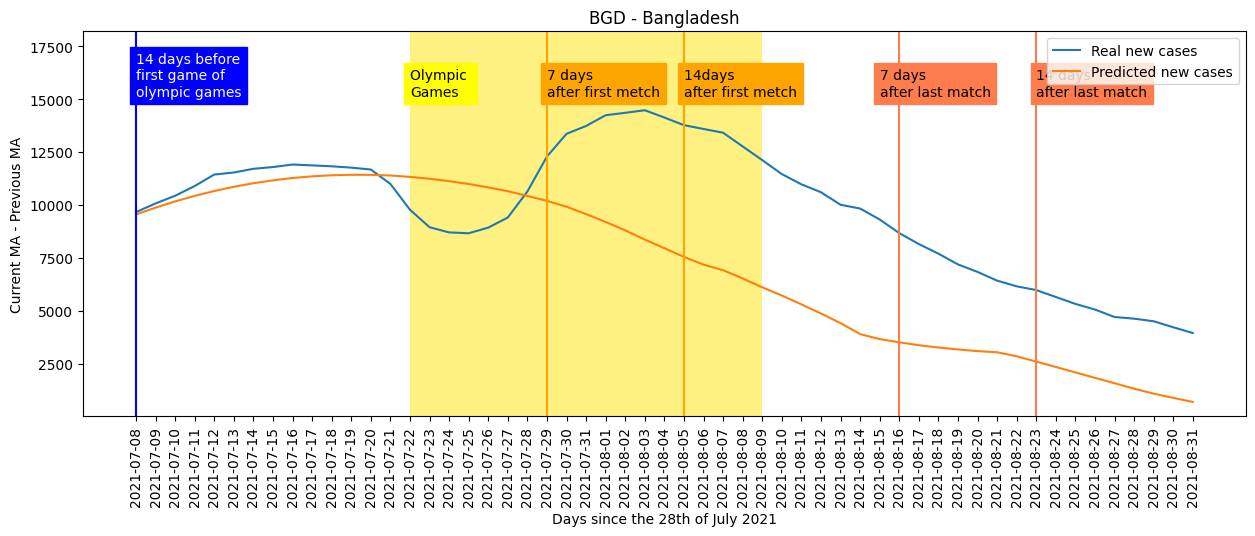

2021-01-05
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=2614.709, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=3145.244, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=2358.536, Time=0.49 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=3175.855, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=2356.544, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=2358.542, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=2358.536, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=2358.572, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=inf, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 2.890 seconds
Performing stepwise searc

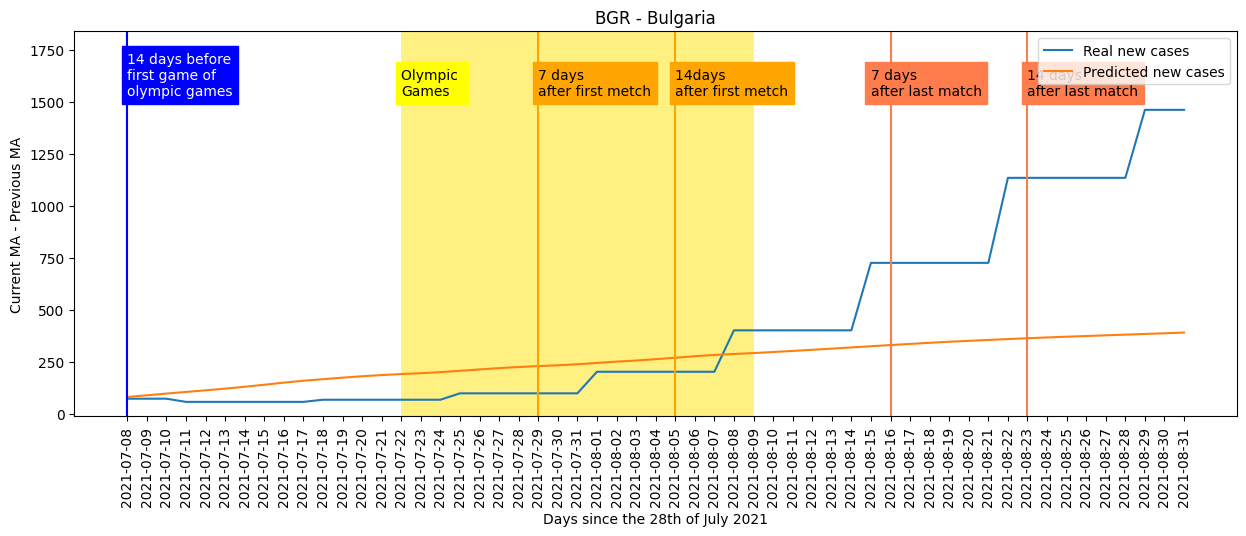

2020-12-30
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=2441.021, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2905.319, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=1990.261, Time=0.39 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=2903.332, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=1986.907, Time=0.81 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=1989.157, Time=0.82 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=2407.904, Time=0.60 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=1845.072, Time=0.98 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=1870.629, Time=0.72 sec
 ARIMA(2,0,0)(2,0,1)[4] intercept   : AIC=1845.345, Time=1.65 sec
 ARIMA(2,0,0)(1,0,1)[4] intercept   : AIC=1860.567, Time=0.73 sec
 ARIMA(3,0,0)(2,0,0)[4] in

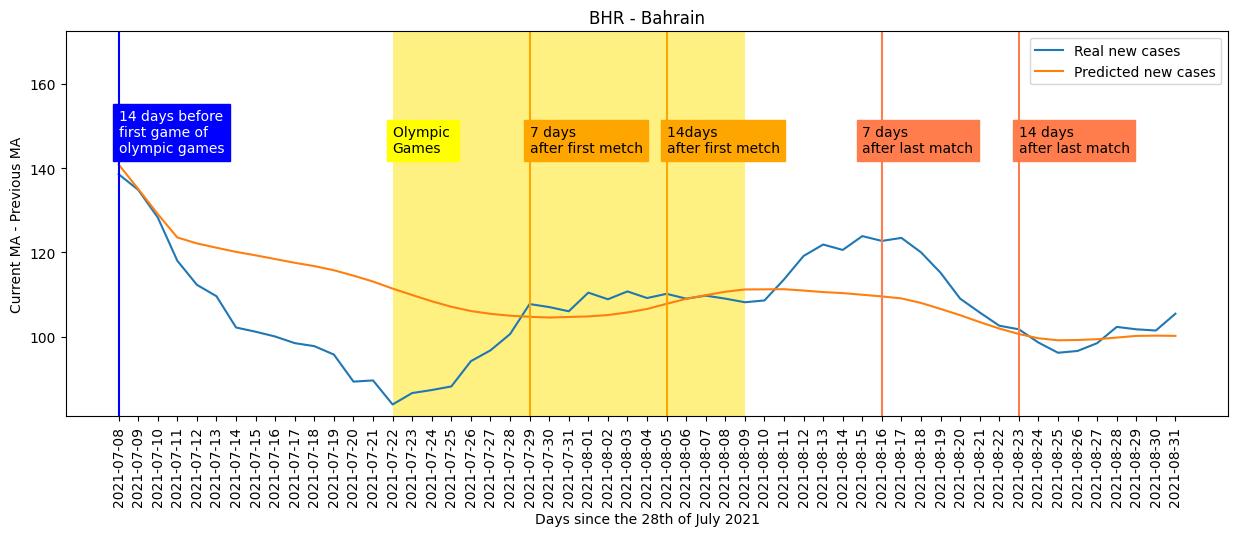

2021-03-20
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=808.343, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=890.007, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=666.277, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=959.763, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=664.289, Time=0.06 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=666.278, Time=0.13 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=665.821, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=665.547, Time=0.12 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=655.985, Time=0.17 sec
 ARIMA(2,0,1)(1,0,0)[4] intercept   : AIC=657.941, Time=0.44 sec
 ARIMA(2,0,1)(0,0,1)[4] intercept   : AIC=657.951, Time=0.38 sec
 ARIMA(2,0,1)(1,0,1)[4] intercept   :

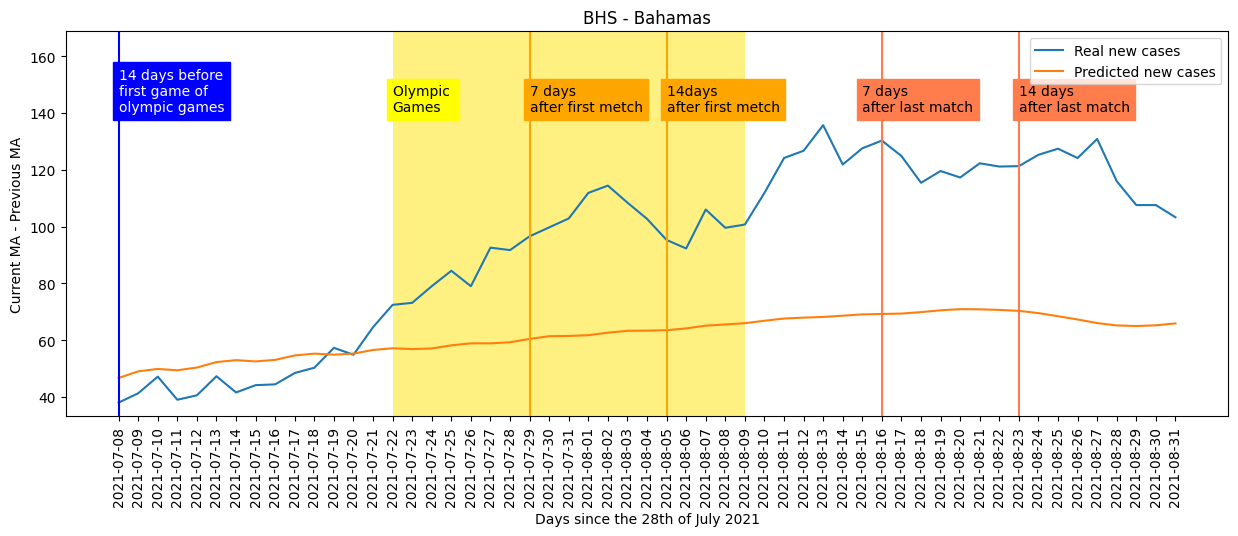

2021-02-18
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=1682.911, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2060.055, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=2256.225, Time=0.04 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(1,0,2)[4] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=1836.451, Time=0.42 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=1616.263, Time=0.66 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=1413.304, Time=0.79 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=1424.128,

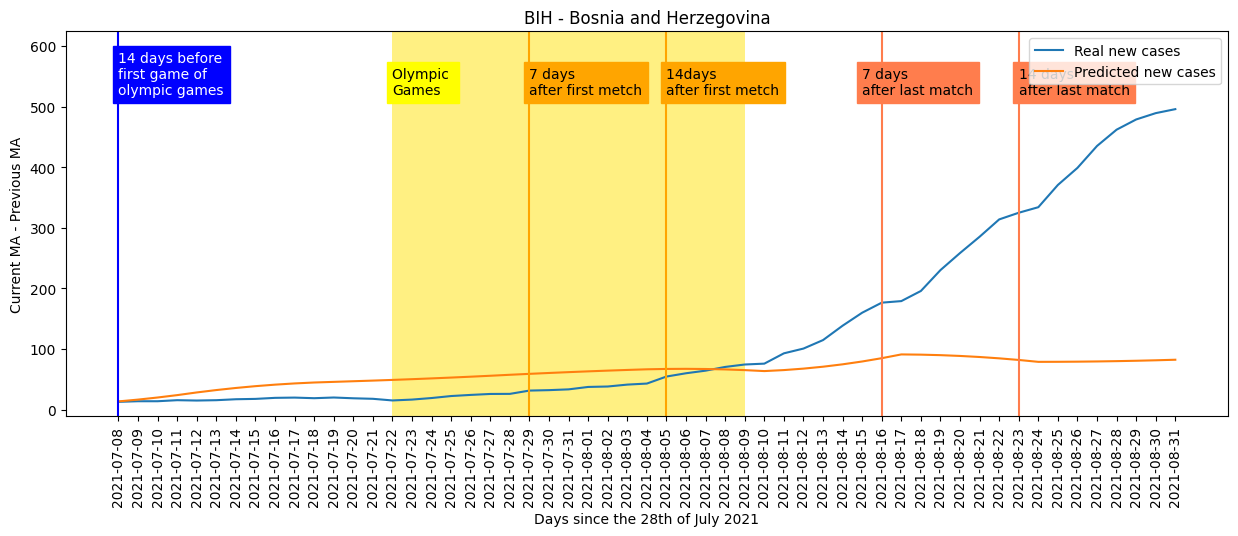

Error in BLM: 'BLM'
2021-01-04
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.36 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2891.873, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=3110.339, Time=0.07 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=2340.317, Time=0.17 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=2297.856, Time=0.84 sec
 ARIMA(0,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=inf, Time=0.62 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=2119.778, Time=0.62 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=2063.880, Time=0.53 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=2301.535, Time=0.27 sec
 ARIMA(0,0,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,1)(2,0,1)[4] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(1,0,1)(1,0,0)[4] in

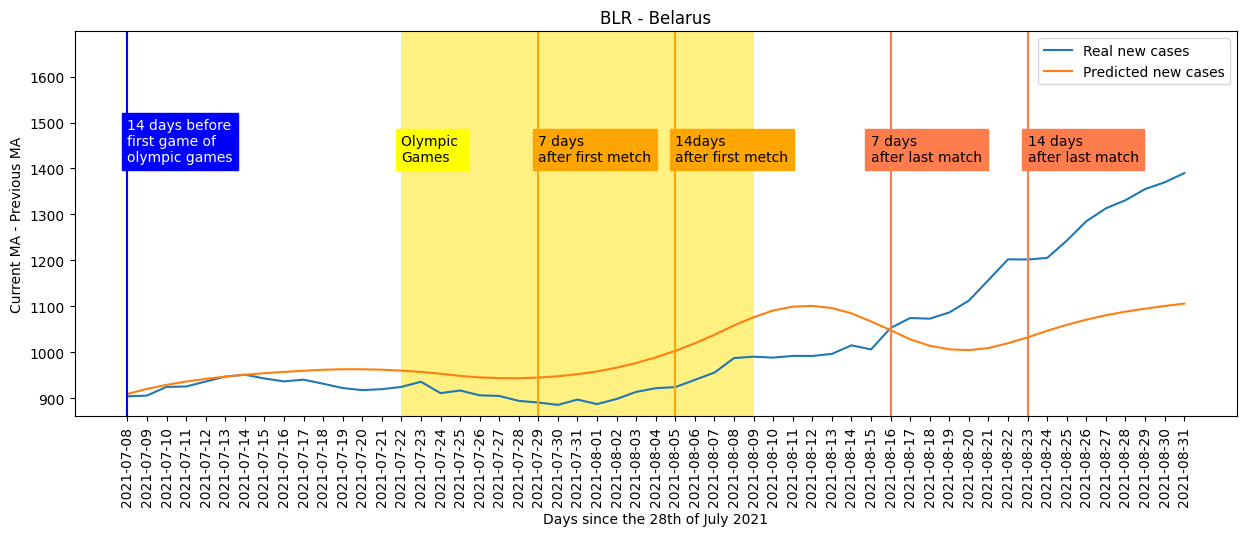

2021-03-07
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=614.244, Time=0.38 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=753.620, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=416.754, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=565.364, Time=0.32 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=752.353, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=417.273, Time=0.13 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=416.708, Time=0.22 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=416.885, Time=0.69 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=417.994, Time=0.42 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=609.971, Time=0.22 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=417.312, Time=0.57 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=417.533, Time=0.67 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=510.752, Time=0.80 sec
 ARIMA(2,0,1)(2,0,0)[4] intercept   : AIC=420.274, Time=0.77 sec
 ARIMA(1,0,0)(2,0,0)[4]  

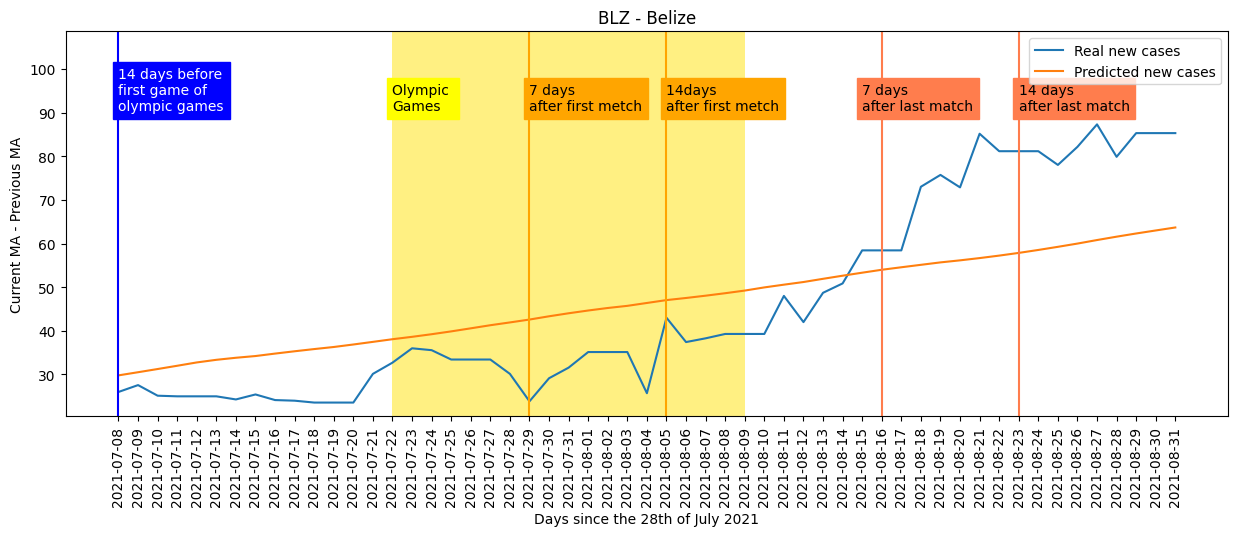

2021-01-17
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=1114.186, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=1431.097, Time=0.10 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=878.530, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=1146.143, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1446.040, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=882.353, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=863.807, Time=0.27 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=865.074, Time=0.52 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=874.694, Time=0.23 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=1101.942, Time=0.27 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=855.909, Time=0.36 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=866.938, Time=0.49 sec
 ARIMA(2,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=1.17 sec
 ARIMA(2,0,0)(1,0,1)[4] intercept   : AIC=863.368, Time=0.57 sec
 ARIMA(3,0,0)(2,0,0)[4] 

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=858.685, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=867.313, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=872.407, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=862.326, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=847.984, Time=0.13 sec
 ARIMA(1,1,0)(2,0,1)[4] intercept   : AIC=849.974, Time=0.15 sec
 ARIMA(1,1,0)(1,0,1)[4] intercept   : AIC=855.278, Time=0.18 sec
 ARIMA(0,1,0)(2,0,0)[4] intercept   : AIC=857.098, Time=0.09 sec
 ARIMA(2,1,0)(2,0,0)[4] intercept   : AIC=817.724, Time=0.15 sec
 ARIMA(2,1,0)(1,0,0)[4] intercept   : AIC=816.915, Time=0.17 sec
 ARIMA(2,1,0)(0,0,0)[4] intercept   : AIC=826.946, Time=0.07 sec
 ARIMA(2,1,0)(1,0,1)[4] intercept   : AIC=818.046, Time=0.16 sec
 ARIMA(2,1,0)(0,0,1)[4] intercept   : AIC=820.532, Time=0.10 sec
 ARIMA(2,1,0)(2,0,1)[4] intercept   : AIC=819.507, Time=0.32 sec
 ARIMA(3,1,0)(1,0,0)[4] intercept   : AIC=813.756, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[4] i

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,2,0)(1,0,0)[4]             : AIC=831.514, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=872.950, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=856.560, Time=0.11 sec
 ARIMA(1,2,0)(2,0,0)[4]             : AIC=833.487, Time=0.14 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=833.484, Time=0.12 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=834.300, Time=0.08 sec
 ARIMA(1,2,0)(2,0,1)[4]             : AIC=833.391, Time=0.35 sec
 ARIMA(0,2,0)(1,0,0)[4]             : AIC=1024.665, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=822.087, Time=0.07 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=827.571, Time=0.04 sec
 ARIMA(2,2,0)(2,0,0)[4]             : AIC=824.085, Time=0.17 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=824.086, Time=0.12 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=823.035, Time=0.07 sec
 ARIMA(2,2,0)(2,0,1)[4]             : AIC=826.087, Time=0.29 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=811.725, Time=0.12 sec
 ARIMA(3,2,0)(0,0,0)[4] 

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=1114.186, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=1431.097, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=878.530, Time=0.22 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=1146.143, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1446.040, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=882.353, Time=0.12 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=863.807, Time=0.24 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=865.074, Time=0.47 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=874.694, Time=0.20 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=1101.942, Time=0.26 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=855.909, Time=0.36 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=866.938, Time=0.29 sec
 ARIMA(2,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=1.01 sec
 ARIMA(2,0,0)(1,0,1)[4] intercept   : AIC=863.368, Time=0.43 sec
 ARIMA(3,0,0)(2,0,0)[4] intercept   : AIC=824.712, Time=0.55 sec
 ARIMA(3,0,0)(1,0,0)[4] 

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


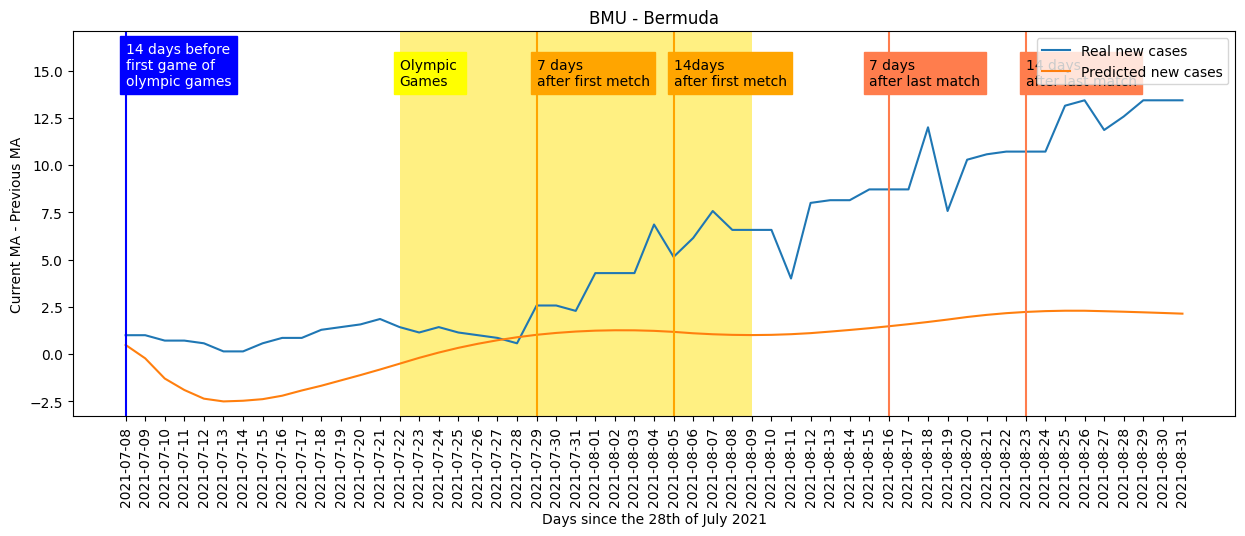

2021-02-09
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=1948.777, Time=0.41 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=2289.282, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=1643.506, Time=0.34 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=2926.776, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=1645.222, Time=0.73 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.41 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=1643.967, Time=0.24 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=1983.629, Time=0.22 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC=1603.859, Time=0.42 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,0,0)(2,0,0)[4] intercept   : AIC=1605.551, Time=0.84 sec
 ARIMA(2,0,0)(1,0,1)[4] intercept   

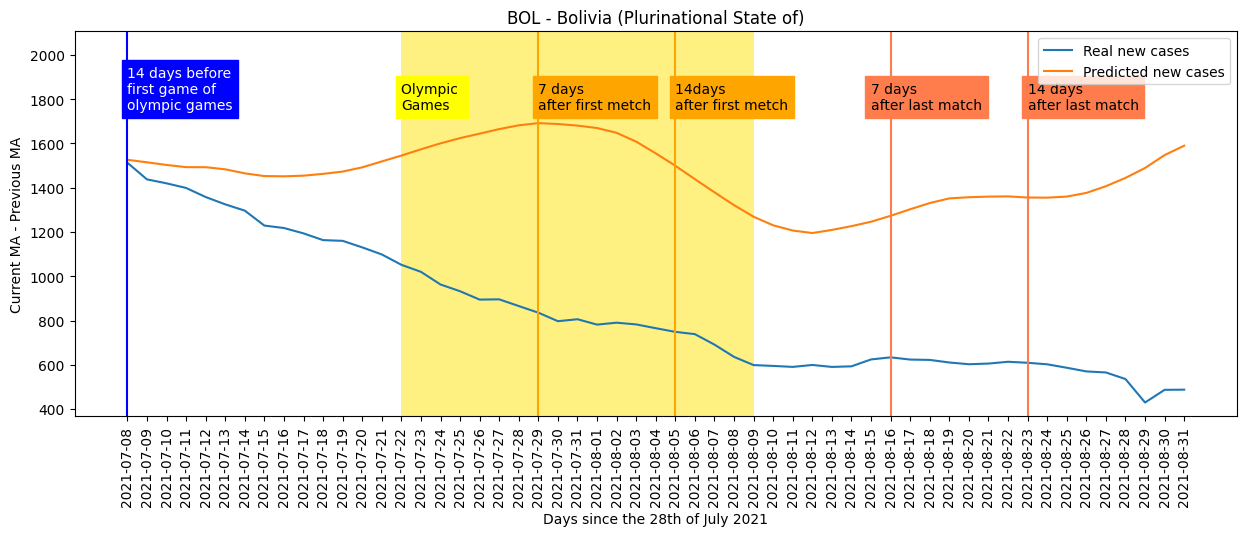

2021-01-24
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=3642.501, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=3761.734, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=3641.860, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=4506.586, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=3662.424, Time=0.09 sec
 ARIMA(0,0,1)(1,0,1)[4] intercept   : AIC=3629.904, Time=0.19 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=3628.485, Time=0.10 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=3630.430, Time=0.16 sec
 ARIMA(0,0,1)(2,0,1)[4] intercept   : AIC=3631.394, Time=0.28 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=3640.609, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : AIC=2986.637, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=2989.789, Time=0.11 sec
 ARIMA(1,0,1)(2,0,0)[4] intercept   : AIC=2942.240, Time=0.86 sec
 ARIMA(1,0,1)(2,

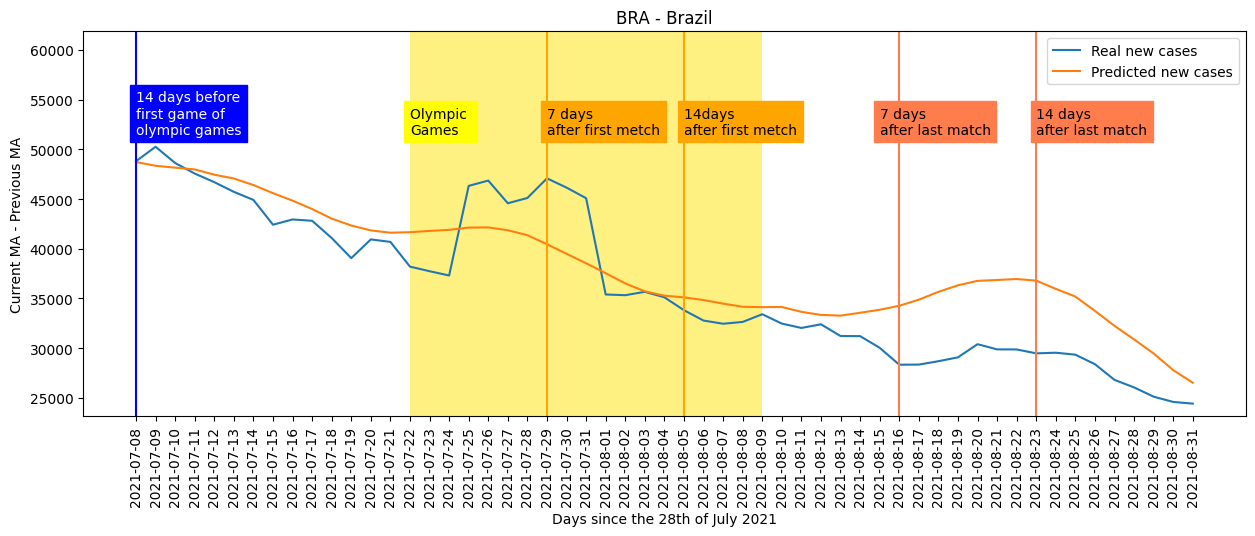

2021-02-22
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=902.512, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=1101.032, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=877.882, Time=0.31 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1099.559, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=958.820, Time=0.10 sec
 ARIMA(0,0,1)(1,0,1)[4] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(0,0,1)(0,0,2)[4] intercept   : AIC=844.220, Time=0.57 sec
 ARIMA(0,0,1)(1,0,2)[4] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(1,0,1)(0,0,2)[4] intercept   : AIC=664.877, Time=0.36 sec
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=662.883, Time=0.25 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=666.167, Time=0.18 sec
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=664.777, Time=0.84 sec
 ARIMA(1,0,1)(1,0,0)[4] intercept   : A

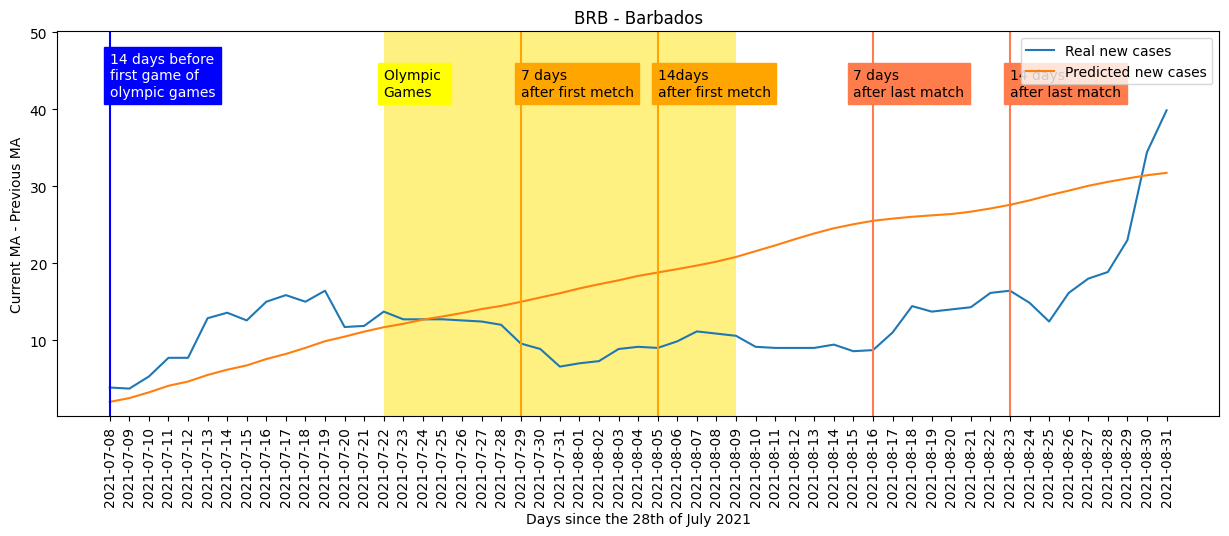

2021-04-09
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=7.414, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=17.101, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=-44.065, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=-17.942, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=33.167, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=-66.088, Time=0.13 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=-66.177, Time=0.26 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=-47.087, Time=0.19 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=-62.598, Time=0.39 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=-36.465, Time=0.29 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=8.818, Time=0.10 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=-35.102, Time=0.21 sec
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=-60.147, Time=0.35 sec
 ARIMA(2,0,1)(0,0,1)[4] intercept   : AIC=-61.312, Time=0.55 sec
 ARIMA(1,0,0)(0,0,1)[4]        

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,0)(1,0,1)[4] intercept   : AIC=-51.233, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-54.403, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-53.084, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-53.538, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-56.330, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=-53.841, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=-53.378, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=-54.119, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=-54.850, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=-54.880, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 0.918 seconds
Performing stepwise search to minimize aic


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,2,0)(1,0,1)[4]             : AIC=14.624, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[4]             : AIC=16.646, Time=0.04 sec
 ARIMA(1,2,0)(1,0,0)[4]             : AIC=-5.578, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[4]             : AIC=inf, Time=0.42 sec
 ARIMA(1,2,0)(0,0,0)[4]             : AIC=-6.289, Time=0.06 sec
 ARIMA(1,2,0)(0,0,1)[4]             : AIC=-5.243, Time=0.27 sec
 ARIMA(1,2,0)(1,0,1)[4]             : AIC=-3.698, Time=0.12 sec
 ARIMA(2,2,0)(0,0,0)[4]             : AIC=-22.445, Time=0.14 sec
 ARIMA(2,2,0)(1,0,0)[4]             : AIC=-20.105, Time=0.12 sec
 ARIMA(2,2,0)(0,0,1)[4]             : AIC=-20.591, Time=0.10 sec
 ARIMA(2,2,0)(1,0,1)[4]             : AIC=-18.765, Time=0.27 sec
 ARIMA(3,2,0)(0,0,0)[4]             : AIC=-23.752, Time=0.13 sec
 ARIMA(3,2,0)(1,0,0)[4]             : AIC=-38.596, Time=0.56 sec
 ARIMA(3,2,0)(2,0,0)[4]             : AIC=-46.984, Time=0.86 sec
 ARIMA(3,2,0)(2,0,1)[4]             : AIC=-46.808, Time=0.97 sec
 ARIMA(3,2,0)(1,0,1)[4]            

/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-53.084, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-53.538, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-56.330, Time=0.05 sec
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=-53.841, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[4] intercept   : AIC=-53.378, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=-54.119, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=-54.850, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[4] intercept   : AIC=-54.880, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[4]          
Total fit time: 0.890 seconds


/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


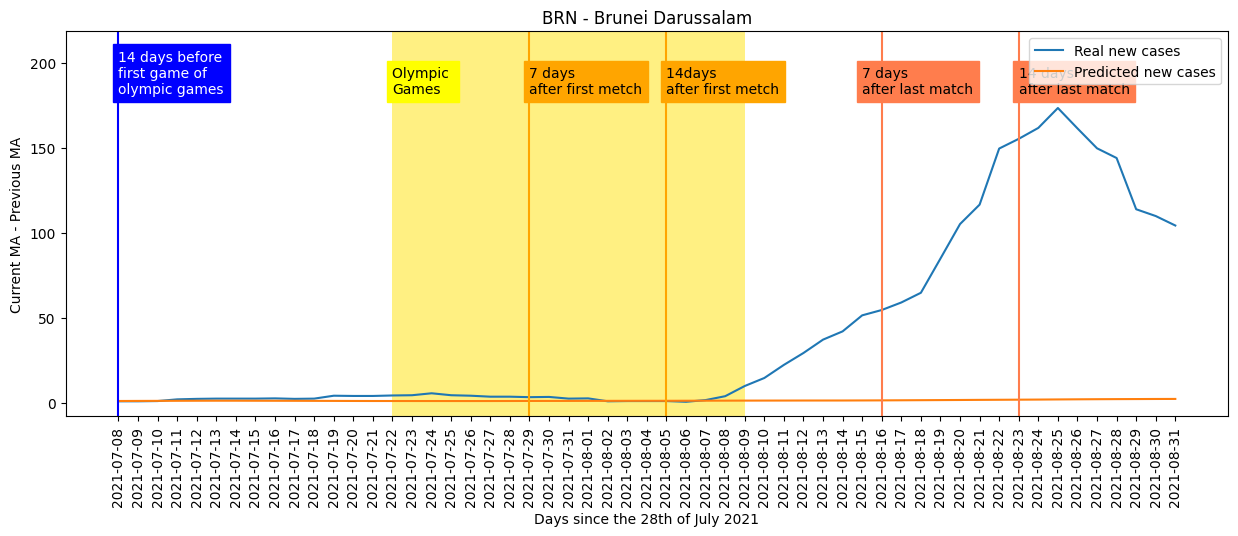

2021-04-02
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=627.952, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=611.285, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1149.377, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=595.602, Time=0.05 sec
 ARIMA(0,0,1)(1,0,0)[4] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,0,1)(1,0,1)[4] intercept   : AIC=517.487, Time=0.38 sec
 ARIMA(0,0,1)(2,0,1)[4] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,0,1)(1,0,2)[4] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,1)(0,0,2)[4] intercept   : AIC=588.549, Time=0.10 sec
 ARIMA(0,0,1)(2,0,0)[4] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,1)(2,0,2)[4] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(1,0,1)(1,0,1)[4] intercept   : AIC=453.378, Time=0.63 sec
 ARIMA(1,0,1)(0,0,1)[4] intercept   : AIC=619.062, T

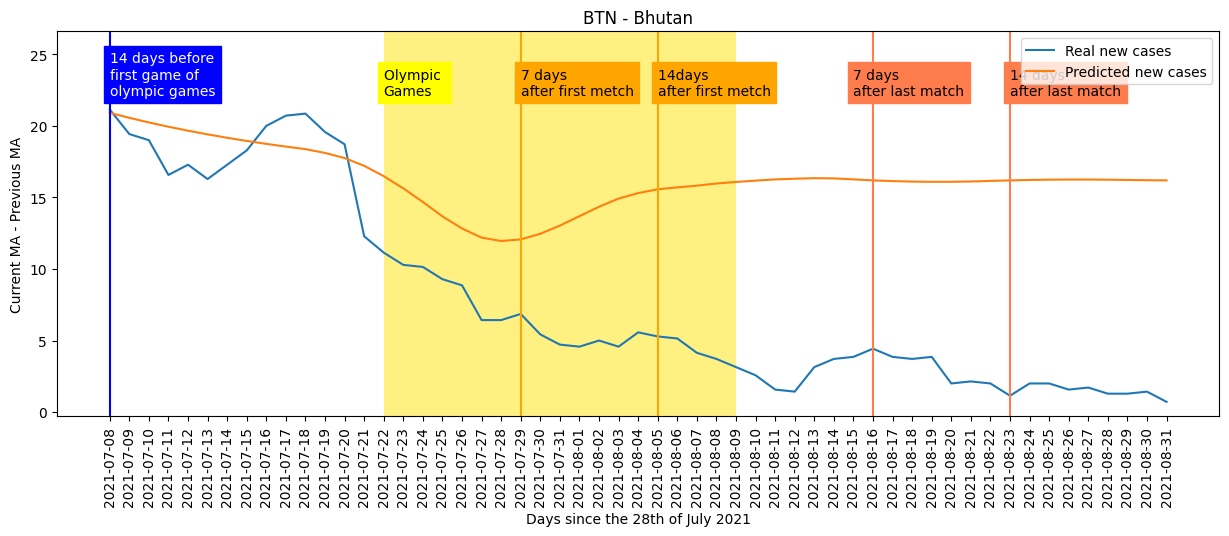

2021-04-01
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=1231.962, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=1261.688, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=1132.432, Time=0.19 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=1173.576, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=1342.810, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=1132.309, Time=0.09 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=1132.332, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=1134.286, Time=0.44 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=1133.788, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[4] intercept   : AIC=1133.869, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[4] intercept   : AIC=1195.420, Time=0.12 sec
 ARIMA(2,0,1)(0,0,0)[4] intercept   : AIC=1133.237, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[4]             : AIC=1138.236, Time=0.05 sec

Best model:  ARIMA(1,0,0)(0,0,0)[4] intercept
Total fit time: 2.439 seconds


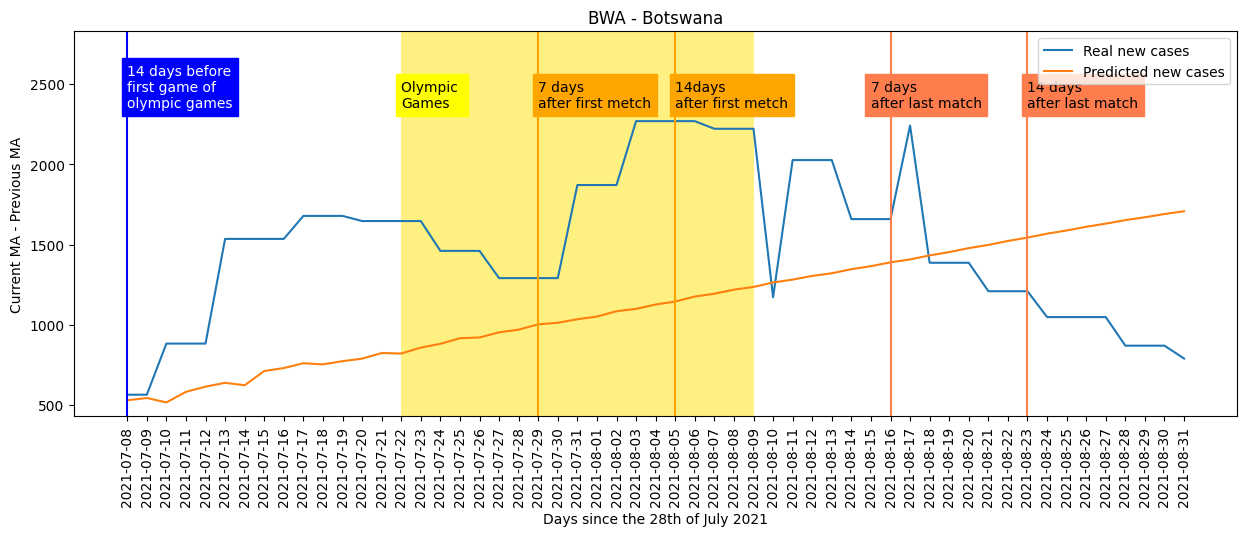

2021-05-19
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=285.441, Time=0.20 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=337.965, Time=0.08 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=185.373, Time=0.18 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=369.118, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[4] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,0,0)(2,0,0)[4] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=186.560, Time=0.27 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=184.859, Time=0.20 sec
 ARIMA(1,0,0)(0,0,2)[4] intercept   : AIC=186.465, Time=0.26 sec
 ARIMA(1,0,0)(1,0,2)[4] intercept   : AIC=188.547, Time=0.39 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(2,0,0)(0,0,1)[4] intercept   : AIC=179.781, Time=0.27 sec
 ARIMA(2,0,0)(0,0,0)[4] intercept   : AIC=178.042, Time=0.16 sec
 ARIMA(2,0,0)(1,0,0)[4] intercept   : AIC

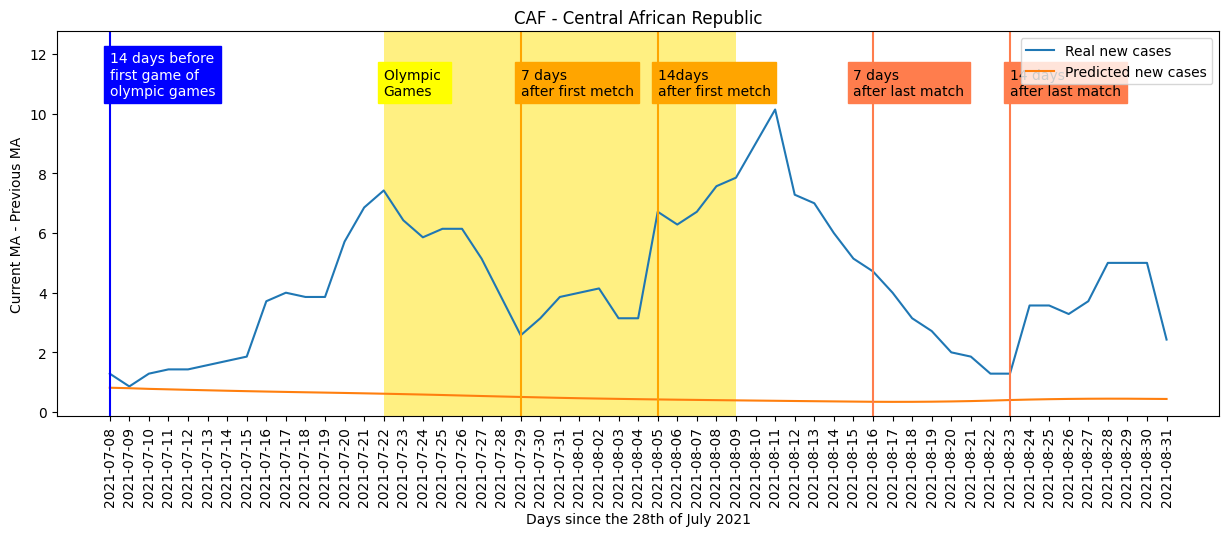

2020-12-21
2021-07-07
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[4] intercept   : AIC=3650.561, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[4] intercept   : AIC=3782.463, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[4] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,1)(0,0,1)[4] intercept   : AIC=inf, Time=0.50 sec
 ARIMA(0,0,0)(0,0,0)[4]             : AIC=4759.841, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[4] intercept   : AIC=3685.789, Time=0.12 sec
 ARIMA(0,0,0)(1,0,0)[4] intercept   : AIC=3652.739, Time=0.12 sec
 ARIMA(0,0,0)(2,0,1)[4] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(1,0,2)[4] intercept   : AIC=3651.626, Time=0.25 sec
 ARIMA(0,0,0)(0,0,2)[4] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,0)(2,0,0)[4] intercept   : AIC=3653.711, Time=0.42 sec
 ARIMA(0,0,0)(2,0,2)[4] intercept   : AIC=inf, Time=0.80 sec
 ARIMA(1,0,0)(1,0,1)[4] intercept   : AIC=2428.740, Time=0.87 sec
 ARIMA(1,0,0)(0,0,1)[4] intercept   : AIC=2484.535, Time=0.39 sec
 ARIMA(1,0,0)(2,0,1)[4] intercept   

KeyboardInterrupt: 

In [99]:
tabella = pd.DataFrame(columns=['State','First_vaccine_date','Full','Before','first_week','first_second_week','before_last_game','second_seven_week','second_second_week','After','RMSE'])
split_date = date(2021, 7, 7)
rmse_mean = 0
counter = 0

trend_positive = []
trend_negative = []

first_week_trend_positive = []
first_week_trend_negative = []
first_second_week_trend_positive = []
first_second_week_trend_negative = []
second_week_trend_positive = []
second_week_trend_negative = []
second_second_week_trend_positive = []
second_second_week_trend_negative = []

#print(iso_code_list)

for code in iso_code_list:
    try:
        # STEP 1: crea un df con solo data e valore per ogni stato
        df_cases = pd.DataFrame(df_new_cases.loc[code]['moving_average_new_cases'].values, index = df_new_cases.loc[code]['moving_average_new_cases'].index, columns = ['moving_average_new_cases'])
        df_vaccin = pd.DataFrame(df_vaccination.loc[code]['moving_average_new_vaccinations'].values, index = df_vaccination.loc[code]['moving_average_new_vaccinations'].index, columns = ['moving_average_new_vaccinations'])
        
        # STEP 2: mergia i due df in uno solo
        merged_df = df_cases.merge(df_vaccin, on=['date'])
        merged_df.to_csv(f"./out/ARIMA/tmp/merged_df_{code}.csv")
        
        #find split date for df_vaccin that indicate first value not null of 0 for moving_average_new_vaccinations
        first_date = merged_df.loc[merged_df['moving_average_new_vaccinations'] > 0].index[0]
        last_date = str(split_date.strftime("%Y-%m-%d"))
        
        print(first_date)
        print(last_date)
        
        merged_df_train = merged_df.loc[(merged_df.index >= first_date) & (merged_df.index <= last_date)].copy()
        merged_df_test = merged_df.loc[merged_df.index > last_date].copy()
        
        merged_df_train.to_csv(f"./out/ARIMA/tmp/merged_df_train_{code}.csv")
        merged_df_test.to_csv(f"./out/ARIMA/tmp/merged_df_test_{code}.csv")
        
        #print(merged_df_train)
        #print(merged_df_test)
        
        best_model, best_pred, best_d, min_rmse = train_model(merged_df_train, merged_df_test)
        
        # STEP 4: crea un modello auto_ARIMA per predirre i new_cases considerando i vaccini fino 2 settimane prima dell'inizio delle olimpiadi
        model = pm.auto_arima(merged_df_train['moving_average_new_cases'], X=merged_df_train[["moving_average_new_vaccinations"]], start_p=0, start_q=0,
                                    test='adf',       # use adftest to find optimal 'd'
                                    max_p=3, max_q=3, # maximum p and q
                                    d=best_d,          # let model determine 'd'
                                    m=4,              # frequency of series
                                    error_action='ignore',
                                    stagionality=True,
                                    suppress_warnings=True,
                                    random_state=42,
                                    maxiter=500, stationary=False,
                                    trace=True,)
        
        length = len(merged_df_test)
        pred, ci = model.predict(n_periods=length, X=merged_df_test[["moving_average_new_vaccinations"]], alpha=0.05, return_conf_int=True)
        
        
        #STEP 5: dividi il test set in 3 parti: 14 giorni prima, durante le olimpiadi e 14 giorni dopo    
        before_olympic = merged_df_test.loc[merged_df_test.index <= str(split_date + timedelta(days=21))].copy()
        first_seven_week = merged_df_test.loc[(merged_df_test.index > str(split_date + timedelta(days=21))) & (merged_df_test.index <= str(split_date + timedelta(days=28)))].copy()
        first_second_week = merged_df_test.loc[(merged_df_test.index > str(split_date + timedelta(days=28))) & (merged_df_test.index <= str(split_date + timedelta(days=35)))].copy()
        before_last_game = merged_df_test.loc[(merged_df_test.index > str(split_date + timedelta(days=35))) & (merged_df_test.index <= str(split_date + timedelta(days=39)))].copy()
        second_seven_week = merged_df_test.loc[(merged_df_test.index > str(split_date + timedelta(days=39))) & (merged_df_test.index <= str(split_date + timedelta(days=46)))].copy()
        second_second_week = merged_df_test.loc[(merged_df_test.index > str(split_date + timedelta(days=46))) & (merged_df_test.index <= str(split_date + timedelta(days=53)))].copy()
        after_olympic = merged_df_test.loc[merged_df_test.index > str(split_date + timedelta(days=53))].copy()
        
        #STEP 6: predici i new_cases
        full_olympic_predicted = model.predict(n_periods=len(merged_df_test), X=merged_df_test[["moving_average_new_vaccinations"]])
        
        # STEP 6.1: sementa la previsione 
        before_olympic_predicted = full_olympic_predicted[:21]
        first_seven_week__predicted = full_olympic_predicted[21:28]
        first_second_week_predicted = full_olympic_predicted[28:35]
        before_last_game_prediction = full_olympic_predicted[35:39]
        second_seven_week_predicted = full_olympic_predicted[39:46]
        second_second_week_predicted = full_olympic_predicted[46:53]
        after_olympic_predicted = full_olympic_predicted[53:]
        
        #STEP 7: calcola la media dei new_cases predetti per ogni parte del test set
        full_olympic_mean_predicted = full_olympic_predicted.mean()
        before_olympic_mean_predicted = full_olympic_predicted[:21].mean()
        first_seven_week_mean_predicted = full_olympic_predicted[21:28].mean()
        first_second_week_mean_predicted = full_olympic_predicted[28:35].mean()
        before_last_game_mean_predicted = full_olympic_predicted[35:39].mean()
        second_seven_week_mean_predicted = full_olympic_predicted[39:46].mean()
        second_second_week_mean_predicted = full_olympic_predicted[46:53].mean()
        after_olympic_mean_predicted = full_olympic_predicted[53:].mean()
        
        #STEP 8: calcola la differenza tra la media dei new_cases predetti e la media dei new_cases reali
        full_olympic_difference = full_olympic_mean_predicted - merged_df_test['moving_average_new_cases'].mean()
        before_olympic_difference = before_olympic_mean_predicted - before_olympic['moving_average_new_cases'].mean()
        first_seven_week_difference = first_seven_week_mean_predicted - first_seven_week['moving_average_new_cases'].mean()
        first_second_week_difference = first_second_week_mean_predicted - first_second_week['moving_average_new_cases'].mean()
        before_last_game_difference = before_last_game_mean_predicted - before_last_game['moving_average_new_cases'].mean()
        second_seven_week_difference = second_seven_week_mean_predicted - second_seven_week['moving_average_new_cases'].mean()
        second_second_week_difference = second_second_week_mean_predicted - second_second_week['moving_average_new_cases'].mean()
        after_olympic_difference = after_olympic_mean_predicted - after_olympic['moving_average_new_cases'].mean()
        
        #STEP 9: calcola la percentuale di differenza tra la media dei new_cases predetti e la media dei new_cases reali
        full_olympic_percentage_difference = (full_olympic_difference/merged_df_test['moving_average_new_cases'].mean())*100
        before_olympic_percentage_difference = (before_olympic_difference/before_olympic['moving_average_new_cases'].mean())*100
        first_seven_week_percentage_difference = (first_seven_week_difference/first_seven_week['moving_average_new_cases'].mean())*100
        first_second_week_percentage_difference = (first_second_week_difference/first_second_week['moving_average_new_cases'].mean())*100
        before_last_game_percentage_difference = (before_last_game_difference/before_last_game['moving_average_new_cases'].mean())*100
        second_seven_week_percentage_difference = (second_seven_week_difference/second_seven_week['moving_average_new_cases'].mean())*100
        second_second_week_percentage_difference = (second_second_week_difference/second_second_week['moving_average_new_cases'].mean())*100
        after_olympic_percentage_difference = (after_olympic_difference/after_olympic['moving_average_new_cases'].mean())*100
        
        #STEP 10: clacola rmse
        rmse = math.sqrt(mean_squared_error(merged_df_test['moving_average_new_cases'], full_olympic_predicted))
        rmse_mean += rmse
        counter += 1
        
        
        '''zed = np.polyfit(range('2021-07-29', '2021-08-05'), first_seven_week['moving_average_new_cases'], 1)
        p = np.poly1d(zed)
        first_seven_week_trend = p(range(0,7))
        zed2 = np.polyfit(range('2021-08-05', '2021-08-12'), first_second_week['moving_average_new_cases'], 1)
        p2 = np.poly1d(zed2)
        
        lw = 2
        plot_out = [[p,np.arange(0,7+1),range(0,7+1),"#116530"],[p2,np.arange(7,len(first_seven_week['moving_average_new_cases'])),range(7,len(first_seven_week['moving_average_new_cases'])),"#DB3F29"]]
        for p in plot_out:
            print(p[0]," ", p[1], " ", p[2], " ", p[3])
            plt.plot(p[1], p[0](p[2]), color=p[3], linewidth=lw, linestyle="dashdot")
            
        # rifai il plot out per la seconda settimana
        zed3 = np.polyfit(range('2021-08-16', '2021-08-23'), second_seven_week['moving_average_new_cases'], 1)
        p3 = np.poly1d(zed3)
        zed4 = np.polyfit(range('2021-07-23', '2021-08-30'), second_second_week['moving_average_new_cases'], 1)
        p4 = np.poly1d(zed4)
        
        plot_out = [[p3,np.arange(0,8),range(0,8),"#116530"],[p4,np.arange(7,len(second_seven_week['moving_average_new_cases'])),range(7,len(second_seven_week['moving_average_new_cases'])),"#DB3F29"]]
        for p in plot_out:
            print(p[0]," ", p[1], " ", p[2], " ", p[3])
            plt.plot(p[1], p[0](p[2]), color=p[3], linewidth=lw, linestyle="dashdot")'''
        
        
        
        
        #STEP 11: salva tutti i paesi che hanno avuto dei trend positivi nella prima settimana e seconda settimana dopo l'inizio delle olimpiadi e nella prima e seconda settimana dopo la fine delle olimpiadi
        if first_seven_week_percentage_difference > 0:
            first_week_trend_positive.append(code)
        else:
            first_week_trend_negative.append(code)
        
        #STEP 10: salva i risultati in un df
        row = pd.DataFrame.from_dict({'State': code,
                                      'First_vaccine_date': first_date,
                                      'Full': full_olympic_percentage_difference,
                                      'Before': before_olympic_percentage_difference,
                                      'first_week': first_seven_week_percentage_difference,
                                      'first_second_week': first_second_week_percentage_difference,
                                      'before_last_game': before_last_game_percentage_difference,
                                      'second_seven_week': second_seven_week_percentage_difference,
                                      'second_second_week': second_second_week_percentage_difference,
                                      'After': after_olympic_percentage_difference,
                                      'RMSE': rmse,
                                      }, orient='index').T
        tabella = pd.concat([tabella, row], ignore_index=True)
        
        #STEP 11: plot the results
        plt.figure(figsize=(15,5))
        plt.plot(merged_df_test.index, merged_df_test['moving_average_new_cases'], label = 'Real new cases')
        plt.plot(merged_df_test.index, full_olympic_predicted, label = 'Predicted new cases')
        plt.title(code + " - " + df_new_cases.loc[code]['Country'].unique()[0])
        plt.legend()
        
        ymax = plt.ylim()[1]
        plt.ylim(ymax=ymax*1.20)
        
        plt.text('2021-07-08', ymax, "14 days before\nfirst game of\nolympic games", rotation=0, color="white", backgroundcolor="blue")
        plt.text('2021-07-22', ymax, "Olympic \nGames", rotation=0, color="black", backgroundcolor="yellow")
        plt.text("2021-07-29", ymax, "7 days \nafter first metch", rotation=0, backgroundcolor="orange")
        plt.text("2021-08-05", ymax, "14days \nafter first metch", rotation=0, backgroundcolor="orange")
        plt.text('2021-08-15', ymax, "7 days \nafter last match", rotation=0, backgroundcolor="#FF7D4D")
        plt.text('2021-08-23', ymax, "14 days \nafter last match", rotation=0, backgroundcolor="#FF7D4D")
        
        plt.axvline(x = '2021-07-08', color = 'blue', label = '14 days before first game of olympic games')
        plt.axvspan('2021-07-22', '2021-08-09', facecolor='#ffe206', alpha=0.5)
        plt.axvline(x = '2021-07-29', color = 'orange', label = '7 days after first game of olympic games')
        plt.axvline(x = '2021-08-05', color = 'orange', label = '14 days after first game of olympic games')
        plt.axvline(x = '2021-08-16', color = '#FF7D4D', label = '7 days after last game of olympic games')
        plt.axvline(x = '2021-08-23', color = '#FF7D4D', label = '14 days after last game of olympic games')
        
        plt.xlabel("Days since the 28th of July 2021")
        plt.xticks(rotation=90)
        plt.ylabel("Current MA - Previous MA")
        
        #save the plot as a png file
        plt.savefig("../pictures/"+ code + "_intervals" +".png")
        plt.savefig("./out/ARIMA/pictures/"+ code + "_intervals" +".png")
        plt.show()
        
    except Exception as error:
        print("Error in " + code + ": " + str(error))



In [ ]:
rmse_mean = rmse_mean/counter
print("RMSE mean: " + str(rmse_mean))
print(tabella)

In [ ]:
#tabella is the table for changepoints and tabella2 is the table for the intervals
tabella.set_index(tabella['State'])
tabella.to_csv("./out/ARIMA/ARIMA_results.csv", index=False)

In [102]:
def list_must_be_studied(before_list, tabella):
    #filtra la tabella con gli isocode che sono nella lista
    tabella_tmp = tabella.loc[before_list]
    print("len tabella", len(tabella_tmp))
    
    #conta quanti stati hanno avuto un valore del first week intorno a 20 e -20
    first_seven_week_10 = tabella_tmp.loc[(tabella_tmp['first_week'] > -10) & (tabella_tmp['first_week'] < 10)].index.tolist()
    print("First week 10: " + str(len(first_seven_week_10)))
    first_seven_week_20 = tabella_tmp.loc[(tabella_tmp['first_week'] > -20) & (tabella_tmp['first_week'] < 20)].index.tolist()
    print("First week 20: " + str(len(first_seven_week_20)))
    first_seven_week_50 = tabella_tmp.loc[(tabella_tmp['first_week'] > -50) & (tabella_tmp['first_week'] < 50)].index.tolist()
    print("First week 50: " + str(len(first_seven_week_50)))
    
    
    first_second_week_10 = tabella_tmp.loc[(tabella_tmp['first_second_week'] > -10) & (tabella_tmp['first_second_week'] < 10)].index.tolist()
    print("First second week 10: " + str(len(first_second_week_10)))
    first_second_week_20 = tabella_tmp.loc[(tabella_tmp['first_second_week'] > -20) & (tabella_tmp['first_second_week'] < 20)].index.tolist()
    print("First second week 20: " + str(len(first_second_week_20)))
    first_second_week_50 = tabella_tmp.loc[(tabella_tmp['first_second_week'] > -50) & (tabella_tmp['first_second_week'] < 50)].index.tolist()
    print("First second week 50: " + str(len(first_second_week_50)))
    
    
    second_seven_week_10 = tabella_tmp.loc[(tabella_tmp['second_seven_week'] > -10) & (tabella_tmp['second_seven_week'] < 10)].index.tolist()
    print("Second seven week 10: " + str(len(second_seven_week_10)))
    second_seven_week_20 = tabella_tmp.loc[(tabella_tmp['second_seven_week'] > -20) & (tabella_tmp['second_seven_week'] < 20)].index.tolist()
    print("Second seven week 20: " + str(len(second_seven_week_20)))
    second_seven_week_50 = tabella_tmp.loc[(tabella_tmp['second_seven_week'] > -50) & (tabella_tmp['second_seven_week'] < 50)].index.tolist()
    print("Second seven week 50: " + str(len(second_seven_week_50)))
    
    second_second_week_10 = tabella_tmp.loc[(tabella_tmp['second_second_week'] > -10) & (tabella_tmp['second_second_week'] < 10)].index.tolist()
    print("Second second week 10: " + str(len(second_second_week_10)))
    second_second_week_20 = tabella_tmp.loc[(tabella_tmp['second_second_week'] > -20) & (tabella_tmp['second_second_week'] < 20)].index.tolist()
    print("Second second week 20: " + str(len(second_second_week_20)))
    second_second_week_50 = tabella_tmp.loc[(tabella_tmp['second_second_week'] > -50) & (tabella_tmp['second_second_week'] < 50)].index.tolist()
    print("Second second week 50: " + str(len(second_second_week_50)))
    
    row = pd.DataFrame.from_dict({'Errore_medio_limit': '10%',
                                  '7 day first metch': len(first_seven_week_10),
                                  '14 day first metch': len(first_second_week_10),
                                  '7 day second metch': len(second_seven_week_10),
                                  '14 day second metch': len(second_second_week_10),
                                  }, orient='index').T
    row2 = pd.DataFrame.from_dict({'Errore_medio_limit': '20%',
                                  '7 day first metch': len(first_seven_week_20),
                                  '14 day first metch': len(first_second_week_20),
                                  '7 day second metch': len(second_seven_week_20),
                                  '14 day second metch': len(second_second_week_20),
                                  }, orient='index').T
    row3 = pd.DataFrame.from_dict({'Errore_medio_limit': '50%',
                                    '7 day first metch': len(first_seven_week_50),
                                    '14 day first metch': len(first_second_week_50),
                                    '7 day second metch': len(second_seven_week_50),
                                    '14 day second metch': len(second_second_week_50),
                                    }, orient='index').T
    
    tabella_results = pd.concat([row, row2, row3], ignore_index=True)
    return tabella_results

In [103]:
#carica la tabella
tabella = pd.read_csv("./out/ARIMA/ARIMA_results.csv")
tabella = tabella.set_index('State')
numero_stati = len(tabella.index.tolist())
print('Stati: ' + str(numero_stati))

# conta quanti stati hanno avuto un valore del before intorno a 20 e -20
before_olympic_10 = tabella.loc[(tabella['Before'] > -10) & (tabella['Before'] < 10)].index.tolist()
print(before_olympic_10)
print("Before olympic 10: " + str(len(before_olympic_10)))
tabella_results_10 = list_must_be_studied(before_olympic_10, tabella)


print("----------------------------------")
before_olympic_20 = tabella.loc[(tabella['Before'] > -20) & (tabella['Before'] < 20)].index.tolist()
print("Before olympic 20: " + str(len(before_olympic_20)))
tabella_results_20 = list_must_be_studied(before_olympic_20, tabella)


print("----------------------------------")
before_olympic_50 = tabella.loc[(tabella['Before'] > -50) & (tabella['Before'] < 50)].index.tolist()
print("Before olympic 50: " + str(len(before_olympic_50)))
tabella_results_50 = list_must_be_studied(before_olympic_50, tabella)


# calcola rmse medio
rmse_mean = tabella['RMSE'].mean()
print(f"RMSE mean: {str(int(rmse_mean))}%")


Stati: 187
['AIA', 'ARE', 'ARG', 'ARM', 'AUT', 'BGD', 'BHS', 'BLR', 'BRA', 'CHL', 'CHN', 'CPV', 'CRI', 'CYM', 'CYP', 'DJI', 'DNK', 'EGY', 'GGY', 'IDN', 'IND', 'IRQ', 'LUX', 'MDA', 'MMR', 'MNE', 'MNG', 'NIC', 'NPL', 'PAN', 'PER', 'PHL', 'PRY', 'SAU', 'SLV', 'SRB', 'SYC', 'TUR', 'UZB', 'VEN']
Before olympic 10: 40
len tabella 40
First week 10: 13
First week 20: 19
First week 50: 33
First second week 10: 10
First second week 20: 17
First second week 50: 27
Second seven week 10: 9
Second seven week 20: 15
Second seven week 50: 24
Second second week 10: 4
Second second week 20: 11
Second second week 50: 24
----------------------------------
Before olympic 20: 65
len tabella 65
First week 10: 17
First week 20: 26
First week 50: 52
First second week 10: 14
First second week 20: 22
First second week 50: 42
Second seven week 10: 12
Second seven week 20: 20
Second seven week 50: 38
Second second week 10: 6
Second second week 20: 14
Second second week 50: 39
----------------------------------
Bef

In [105]:
print(tabella_results_10)
print(tabella_results_20)
print(tabella_results_50)

# da tabella a tabella latex
tabella_results_10.to_latex("./out/ARIMA/ARIMA_results_10.tex")
tabella_results_20.to_latex("./out/ARIMA/ARIMA_results_20.tex")
tabella_results_50.to_latex("./out/ARIMA/ARIMA_results_50.tex")


  Errore_medio_limit 7 day first metch 14 day first metch 7 day second metch  \
0                10%                13                 10                  9   
1                20%                19                 17                 15   
2                50%                33                 27                 24   

  14 day second metch  
0                   4  
1                  11  
2                  24  
  Errore_medio_limit 7 day first metch 14 day first metch 7 day second metch  \
0                10%                17                 14                 12   
1                20%                26                 22                 20   
2                50%                52                 42                 38   

  14 day second metch  
0                   6  
1                  14  
2                  39  
  Errore_medio_limit 7 day first metch 14 day first metch 7 day second metch  \
0                10%                20                 18                 14   
1     